In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Methods for dealing with class imbalance: oversampling, undersampling, SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Render high resolution images

In [2]:
# import cleaned datasets/ original Kaggle datasets 
train = pd.read_csv("../assets/train.csv")

In [3]:
# No missing values in train data 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [4]:
# drop multiple columns containing address information as they are duplicated info within the dataframe
train.drop(["Address", "Block", "Street", "AddressAccuracy"], axis=1, inplace=True)

In [5]:
train.head(3)

Date                 Species  Trap  \
0  2007-05-29  CULEX PIPIENS/RESTUANS  T002   
1  2007-05-29          CULEX RESTUANS  T002   
2  2007-05-29          CULEX RESTUANS  T007   

              AddressNumberAndStreet   Latitude  Longitude  NumMosquitos  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991             1   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991             1   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279             1   

   WnvPresent  
0           0  
1           0  
2           0

In [6]:
train.shape

(10506, 8)

In [7]:
# check date range of our data
print("Earliest Record: ", train.Date.min())
print("Latest Record: ", train.Date.max())

Earliest Record:  2007-05-29
Latest Record:  2013-09-26


In [8]:
train.describe().T

count       mean        std        min        25%        50%  \
Latitude      10506.0  41.841139   0.112742  41.644612  41.732984  41.846283   
Longitude     10506.0 -87.699908   0.096514 -87.930995 -87.760070 -87.694991   
NumMosquitos  10506.0  12.853512  16.133816   1.000000   2.000000   5.000000   
WnvPresent    10506.0   0.052446   0.222936   0.000000   0.000000   0.000000   

                    75%        max  
Latitude      41.954690  42.017430  
Longitude    -87.627796 -87.531635  
NumMosquitos  17.000000  50.000000  
WnvPresent     0.000000   1.000000

## b) EDA and Feature Engineering

### Feature Engineering for Time Variables

In [9]:
#convert date to datetime
train['Date'] = pd.to_datetime(train['Date'])

In [10]:
#create month, week and year columns to help with prelim EDA 
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.isocalendar().week
train['Year'] = train['Date'].dt.year
train['Year Month'] = train['Date'].dt.strftime('%Y %m')

### Occurences of the West Nile Virus (WNV) peaks in August every year. 

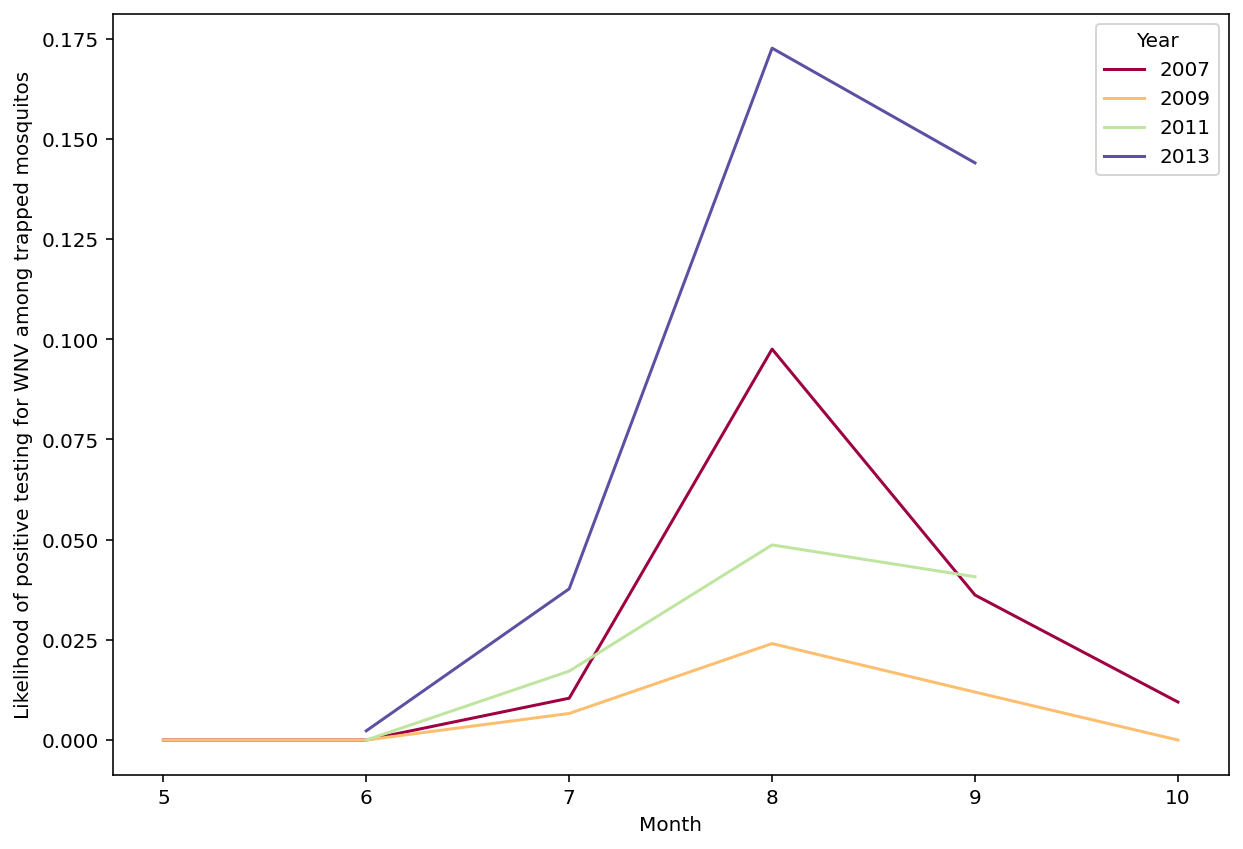

In [11]:
#plot WNV occurrences by month and year
plt.subplots(figsize=(10,7))
sns.lineplot(x='Month', y='WnvPresent', hue='Year', data=train, ci = None, palette = 'Spectral')
plt.ylabel("Likelihood of positive testing for WNV among trapped mosquitos")
plt.show()

### The WNV incidences were highest in August and this corresponds with the highest number of mosquitos collected for testing (likely a result of larger mosquito population sizes in certain months).

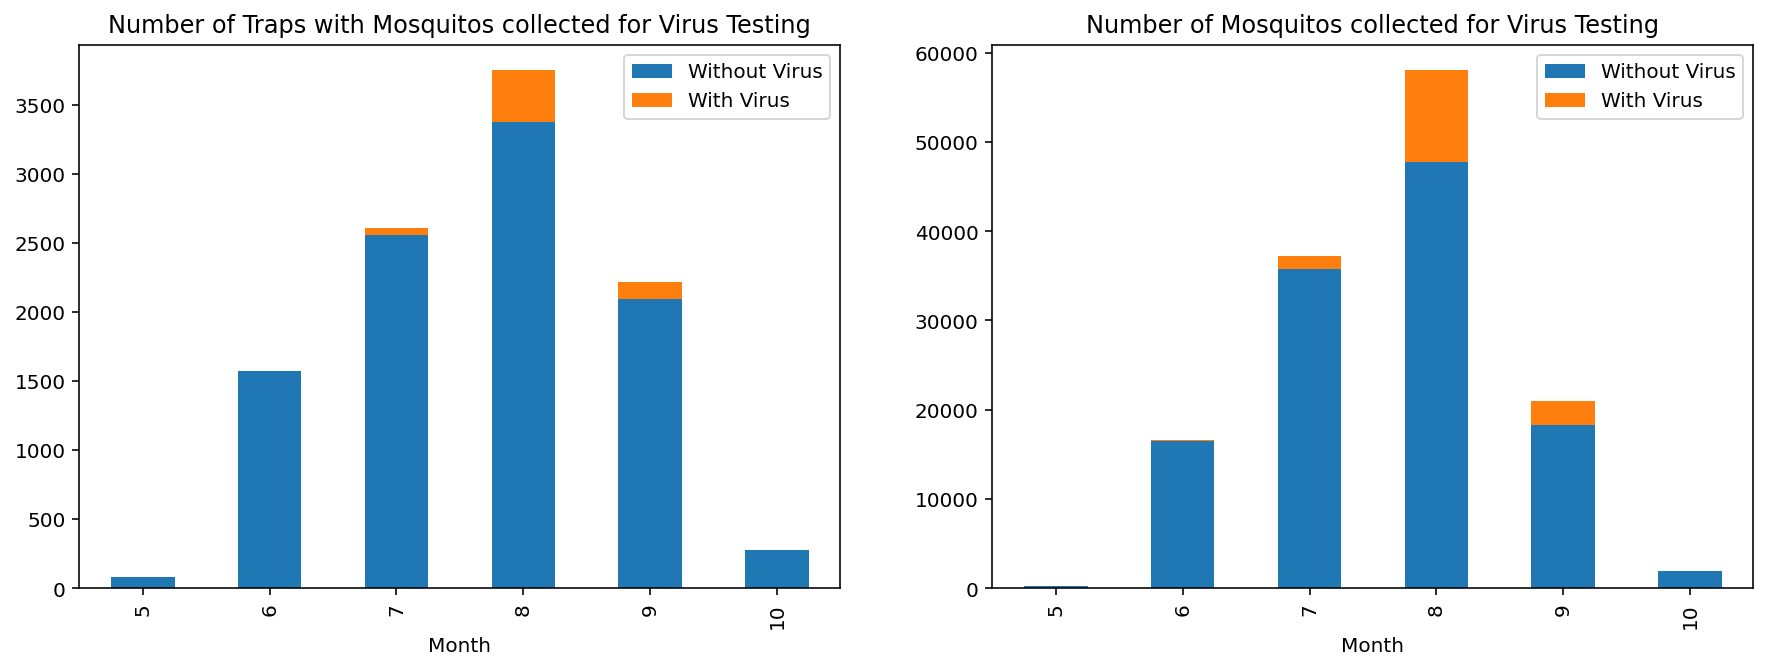

In [12]:
# create pivot to count number of traps collected for virus testing
month_with_virus_count = train.pivot_table(values=['NumMosquitos'], index='Month',
                                       columns='WnvPresent', aggfunc='count')

# create pivot to count number of mosquitos collected for testing 
month_with_virus_sum = train.pivot_table(values=['NumMosquitos'], index='Month',
                                       columns='WnvPresent', aggfunc='sum')

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))

month_with_virus_count.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Number of Traps with Mosquitos collected for Virus Testing")
axes[0].set_xlabel("Month")
axes[0].legend(labels=["Without Virus", "With Virus"])

month_with_virus_sum.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Number of Mosquitos collected for Virus Testing")
axes[1].set_xlabel("Month")
axes[1].legend(labels=["Without Virus", "With Virus"]); 

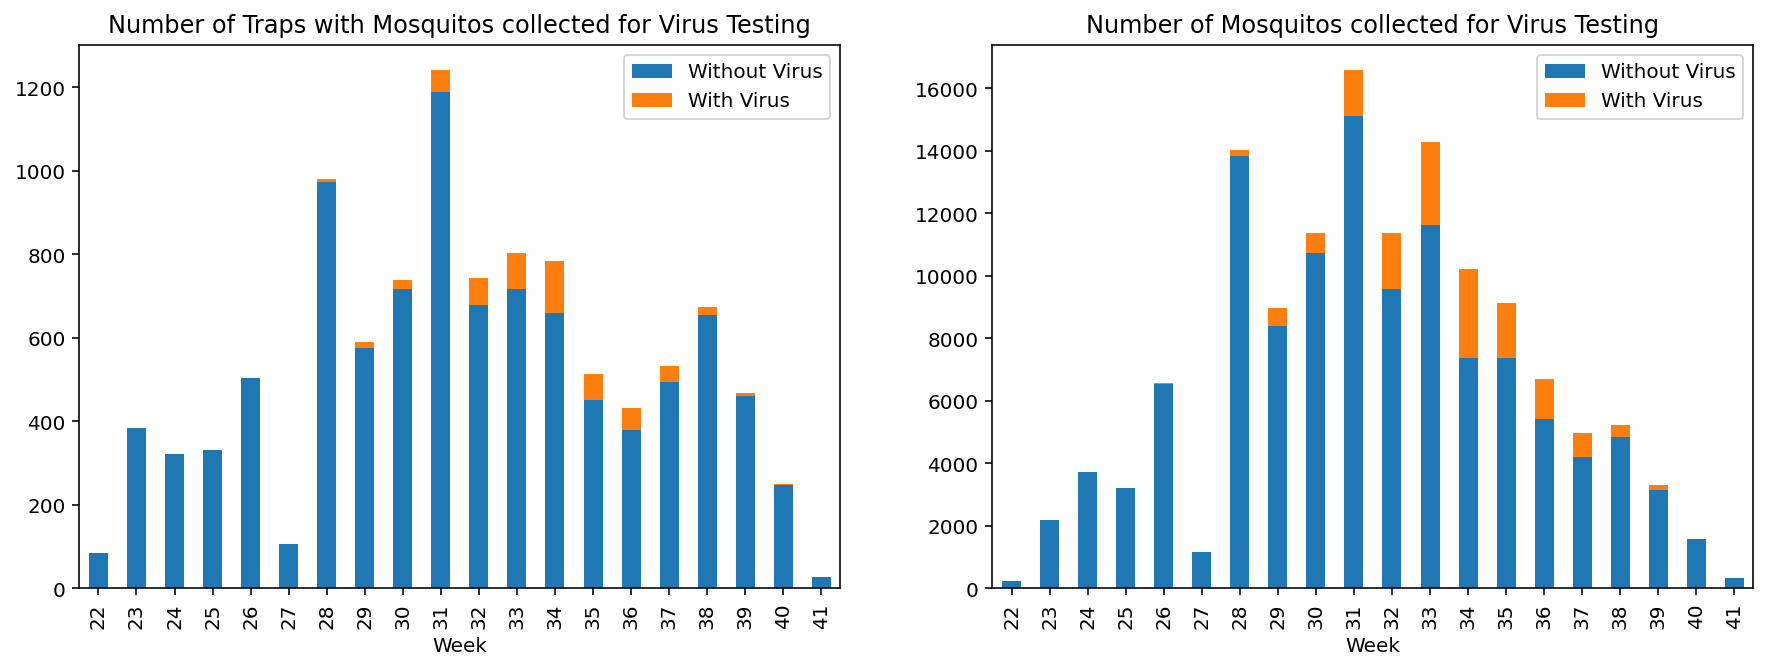

In [13]:
# create pivot to count number of traps collected for virus testing
month_with_virus_count = train.pivot_table(values=['NumMosquitos'], index='Week',
                                       columns='WnvPresent', aggfunc='count')

# create pivot to count number of mosquitos collected for testing 
month_with_virus_sum = train.pivot_table(values=['NumMosquitos'], index='Week',
                                       columns='WnvPresent', aggfunc='sum')

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,5))

month_with_virus_count.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Number of Traps with Mosquitos collected for Virus Testing")
axes[0].set_xlabel("Week")
axes[0].legend(labels=["Without Virus", "With Virus"])

month_with_virus_sum.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title("Number of Mosquitos collected for Virus Testing")
axes[1].set_xlabel("Week")
axes[1].legend(labels=["Without Virus", "With Virus"]); 

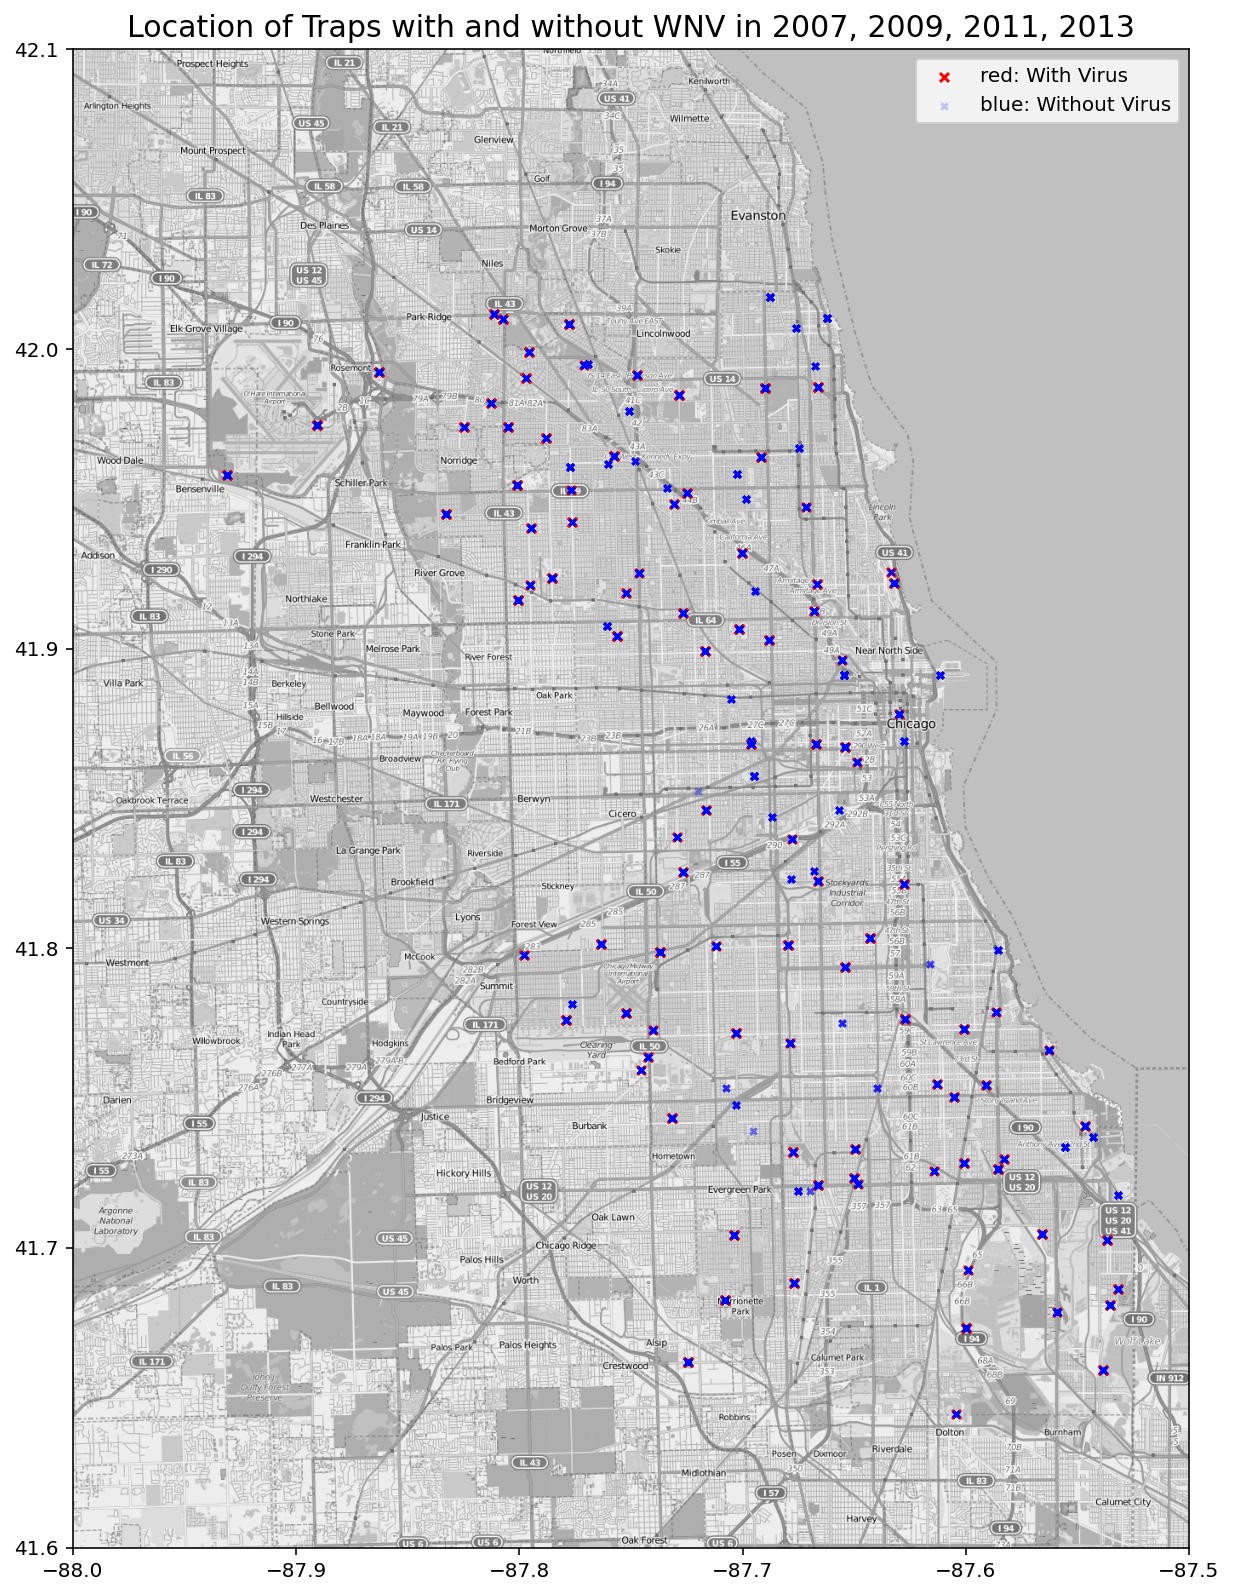

In [14]:
# plot locations of traps and instances of WNV cases
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)


trap_wnv = train.loc[train["WnvPresent"]==1]
trap_clear = train.loc[train["WnvPresent"]==0]

wnv = plt.scatter(trap_wnv['Longitude'], trap_wnv['Latitude'], c="red", marker='x', s=20, alpha=1)
clear = plt.scatter(trap_clear['Longitude'], trap_clear['Latitude'], c="blue", marker='x', s=10, alpha=0.2)

plt.title("Location of Traps with and without WNV in 2007, 2009, 2011, 2013", fontsize=15)
plt.legend((wnv, clear), ("red: With Virus", "blue: Without Virus"));

### Of all the mosquitoes collected, only those belonging to species groups - `Restuans` or `Pipiens` - had tested positive for the virus in the train dataset.

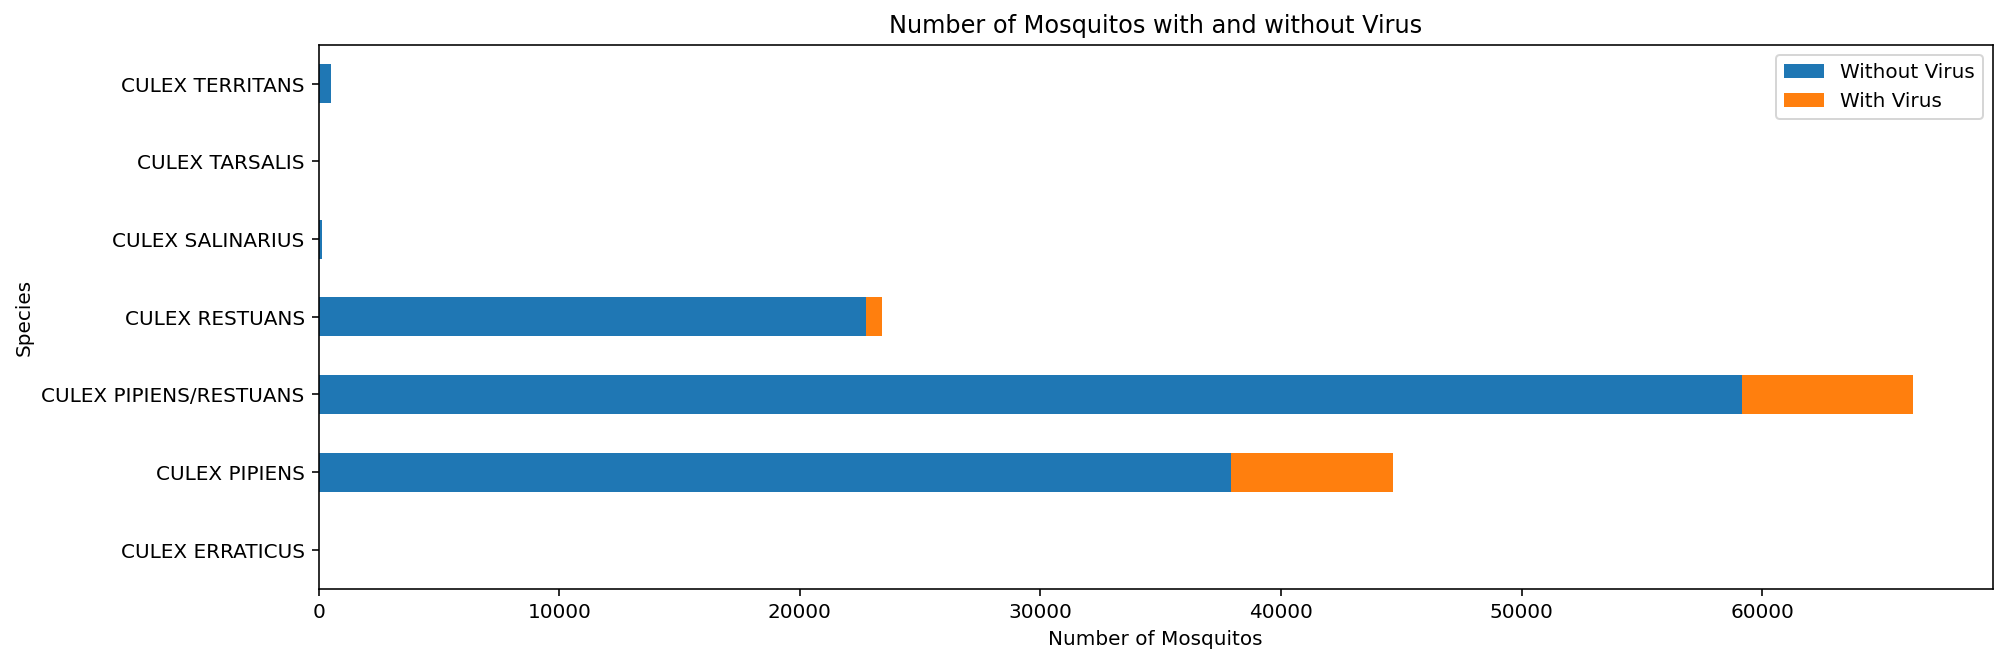

In [15]:
species_with_virus = train.pivot_table(values=['NumMosquitos'], index='Species',
                                       columns='WnvPresent', aggfunc='sum')

species_with_virus.plot(kind='barh', stacked=True, figsize=(15,5))
plt.title("Number of Mosquitos with and without Virus")
plt.xlabel("Number of Mosquitos")
plt.legend(labels=["Without Virus", "With Virus"]);

### Mosquito Species will likely be a useful predictor. We proceed to dummify it. However, we note that there is and `UNSPECIFIED CULEX` species found in the test set.

In [16]:
# print unique species 
train["Species"].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [17]:
species = ["PIPIENS", "RESTUANS"]

# create loop to create dummified variables to indicate presence of Pipiens & Restuans species
for i in species:
    train[i] = 0
    for index, row in train.iterrows():
        if i in row["Species"]:
            train[i][index] = 1 

<ipython-input-17-277c31943e34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i][index] = 1


In [18]:
# drop species column as data has already been stored in dummified variables
train.drop("Species", axis=1, inplace=True)
train.head()

Date  Trap             AddressNumberAndStreet   Latitude  Longitude  \
0 2007-05-29  T002  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
1 2007-05-29  T002  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2 2007-05-29  T007   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   
3 2007-05-29  T015    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
4 2007-05-29  T015    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   

   NumMosquitos  WnvPresent  Month  Week  Year Year Month  PIPIENS  RESTUANS  
0             1           0      5    22  2007    2007 05        1         1  
1             1           0      5    22  2007    2007 05        0         1  
2             1           0      5    22  2007    2007 05        0         1  
3             1           0      5    22  2007    2007 05        1         1  
4             4           0      5    22  2007    2007 05        0         1

### Feature Engineering - Virus Risk
Risk levels computed based on Occurences of WNV in the past at the respective addresses:
- `Very low`: Between 0 and 2 cases of WNV detected
- `Low`: Between 2 and 6 cases
- `Medium`: Between 6 and 10 cases
- `High`: More than 10 cases

In [19]:
# create a pivot table to sum the number of WNV cases detected at each location
wnv_risk = train.pivot_table(values=['WnvPresent'], index='AddressNumberAndStreet', aggfunc='sum')
wnv_risk.describe().T.round()

count  mean  std  min  25%  50%  75%   max
WnvPresent  138.0   4.0  7.0  0.0  0.0  2.0  6.0  66.0

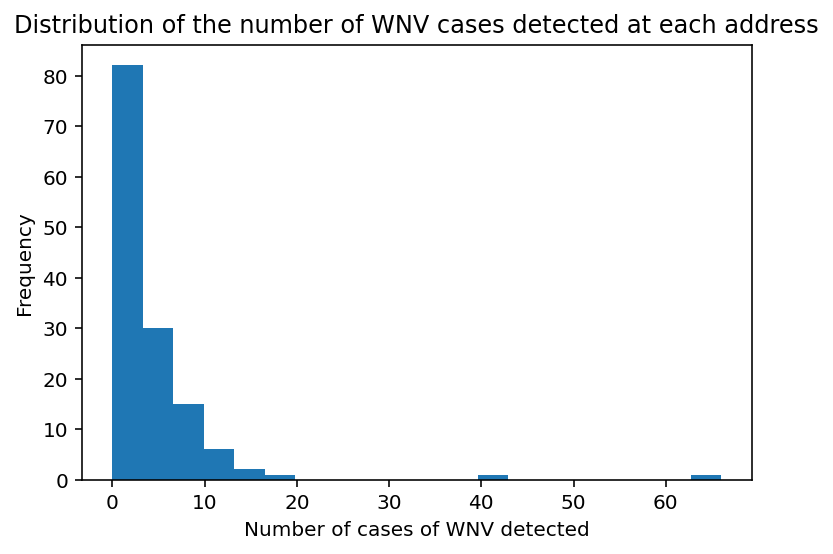

In [20]:
# plot histogram to show the spread in number of WNV cases detected 
plt.title("Distribution of the number of WNV cases detected at each address")
plt.ylabel("Frequency")
plt.xlabel("Number of cases of WNV detected")
plt.hist(wnv_risk, bins=20);

In [21]:
# create feature to assign location risk of WNV
wnv_risk['WNV_risk'] = pd.cut(wnv_risk["WnvPresent"], bins=[0, 2, 6, 10, 100], right=False, labels=['very low', 'low', 'medium', 'high'], ordered=True)
wnv_risk.sort_values('WnvPresent', ascending=False).head(20)

WnvPresent WNV_risk
AddressNumberAndStreet                                    
1000  W OHARE AIRPORT, Chicago, IL             66     high
1200  S DOTY AVE, Chicago, IL                  41     high
4100  N OAK PARK AVE, Chicago, IL              18     high
1000  S STONY ISLAND AVE, Chicago, IL          16     high
4600  N MILWAUKEE AVE, Chicago, IL             14     high
2400  E 105TH ST, Chicago, IL                  11     high
3600  N PITTSBURGH AVE, Chicago, IL            11     high
8200  S KOSTNER AVE, Chicago, IL               11     high
7000  N MOSELL AVE, Chicago, IL                10     high
6100  W FULLERTON AVE, Chicago, IL             10     high
1000  W OHARE, Chicago, IL                     10     high
5800  N WESTERN AVE, Chicago, IL                9   medium
4000  E 130TH ST, Chicago, IL                   9   medium
5200  S KOLMAR, Chicago, IL                     9   medium
5100  N MONT CLARE AVE, Chicago, IL             9   medium
5000  S UNION AVE, Chicago, IL                  8   medium
2200  W 51ST ST, Chicago, IL                    8   medium
1000  N CENTRAL PARK DR, Chicago, IL            8   medium
2200  W 113TH ST, Chicago, IL                   8   medium
4200  W 127TH PL, Chicago, IL                   8   medium

In [22]:
# merge risk data with train data, dummify the categorical variable and drop original
train_merged_df = train.merge(wnv_risk[["WNV_risk"]], how="left", on="AddressNumberAndStreet")
train_merged_df = pd.concat([train_merged_df, pd.get_dummies(train_merged_df["WNV_risk"], prefix="WnvRisk")], axis=1)
train_merged_df.drop(["WNV_risk"], axis=1, inplace=True)

### Merger of Train data with Weather data

In order to merge both the train and weather data, we first need to label the traps based on their proximity to either one of the weather stations. This assignment will allow us to merge and retrieve the weather data for the respective traps. If a trap is located closer to Chicago Midway International Airport than the Chicago O'Hare International Airport, it will be tagged as `Station` = 2, and =1 if otherwise. 

In [23]:
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

# create function to assign observation based on latitude and longitude to either stations
def assign_station(lat:int, lng:int):
    coord_stn1 = (41.995, -87.933)
    coord_stn2 = (41.786, -87.752)
    coord_curr = (lat, lng)
    return 1 if geodesic(coord_curr, coord_stn1) < geodesic(coord_curr, coord_stn2) else 2

In [24]:
# apply the function to create the assignment of observation to weather stations 
train_merged_df['Station'] = train_merged_df.apply(lambda x: assign_station(x['Latitude'], x['Longitude']), axis=1)

In [25]:
# 69% of the traps are located closer to the Chicago Midway International Airport in the train data
train_merged_df["Station"].value_counts(normalize=True)

2    0.686084
1    0.313916
Name: Station, dtype: float64

In [26]:
# import cleaned weather datasets
weather = pd.read_csv("../assets/weather_cleaned.csv")
weather.head()

Station        Date  Tmax  Tmin  Tavg  DewPoint  PrecipTotal  StnPressure  \
0        1  2007-05-01    83    50  66.5        51          0.0        29.10   
1        2  2007-05-01    84    52  68.0        51          0.0        29.18   
2        1  2007-05-02    59    42  50.5        42          0.0        29.38   
3        2  2007-05-02    60    43  51.5        42          0.0        29.44   
4        1  2007-05-03    66    46  56.0        40          0.0        29.39   

   SeaLevel  AvgSpeed  Rain  Mist  RelativeHumidity  
0     29.82       9.2     0     0         57.394895  
1     29.82       9.6     0     0         54.497276  
2     30.09      13.4     0     1         72.508686  
3     30.08      13.4     0     1         69.872482  
4     30.12      11.9     0     0         54.848860

In [27]:
# save weather's Data as pd's datetime format to ensure consistency in data format across different dataframes 
weather['Date'] = pd.to_datetime(weather['Date'])

In [28]:
# merge data 
train_merged_df = train_merged_df.merge(weather, how="left", on=["Station", "Date"])
train_merged_df.head()

Date  Trap             AddressNumberAndStreet   Latitude  Longitude  \
0 2007-05-29  T002  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
1 2007-05-29  T002  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2 2007-05-29  T007   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   
3 2007-05-29  T015    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
4 2007-05-29  T015    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   

   NumMosquitos  WnvPresent  Month  Week  Year  ... Tmin  Tavg  DewPoint  \
0             1           0      5    22  2007  ...   60  74.0        58   
1             1           0      5    22  2007  ...   60  74.0        58   
2             1           0      5    22  2007  ...   60  74.0        58   
3             1           0      5    22  2007  ...   60  74.0        58   
4             4           0      5    22  2007  ...   60  74.0        58   

   PrecipTotal  StnPressure  SeaLevel  AvgSpeed  Rain  Mist  RelativeHumidity  
0          0.0        29.39     30.11       6.5     0     1         57.368792  
1          0.0        29.39     30.11       6.5     0     1         57.368792  
2          0.0        29.39     30.11       6.5     0     1         57.368792  
3          0.0        29.39     30.11       6.5     0     1         57.368792  
4          0.0        29.39     30.11       6.5     0     1         57.368792  

[5 rows x 29 columns]

In [29]:
train_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Trap                    10506 non-null  object        
 2   AddressNumberAndStreet  10506 non-null  object        
 3   Latitude                10506 non-null  float64       
 4   Longitude               10506 non-null  float64       
 5   NumMosquitos            10506 non-null  int64         
 6   WnvPresent              10506 non-null  int64         
 7   Month                   10506 non-null  int64         
 8   Week                    10506 non-null  UInt32        
 9   Year                    10506 non-null  int64         
 10  Year Month              10506 non-null  object        
 11  PIPIENS                 10506 non-null  int64         
 12  RESTUANS                10506 non-null  int64 

### Visualising correlation of features from train set with target 

In [30]:
# create a temporary dataframe and drop categorical data and variables that are not present in test set
df = train_merged_df.drop(["Date", "Station", "AddressNumberAndStreet", "Latitude", "Longitude", 
                              "NumMosquitos", "Year", "Trap"], axis=1)

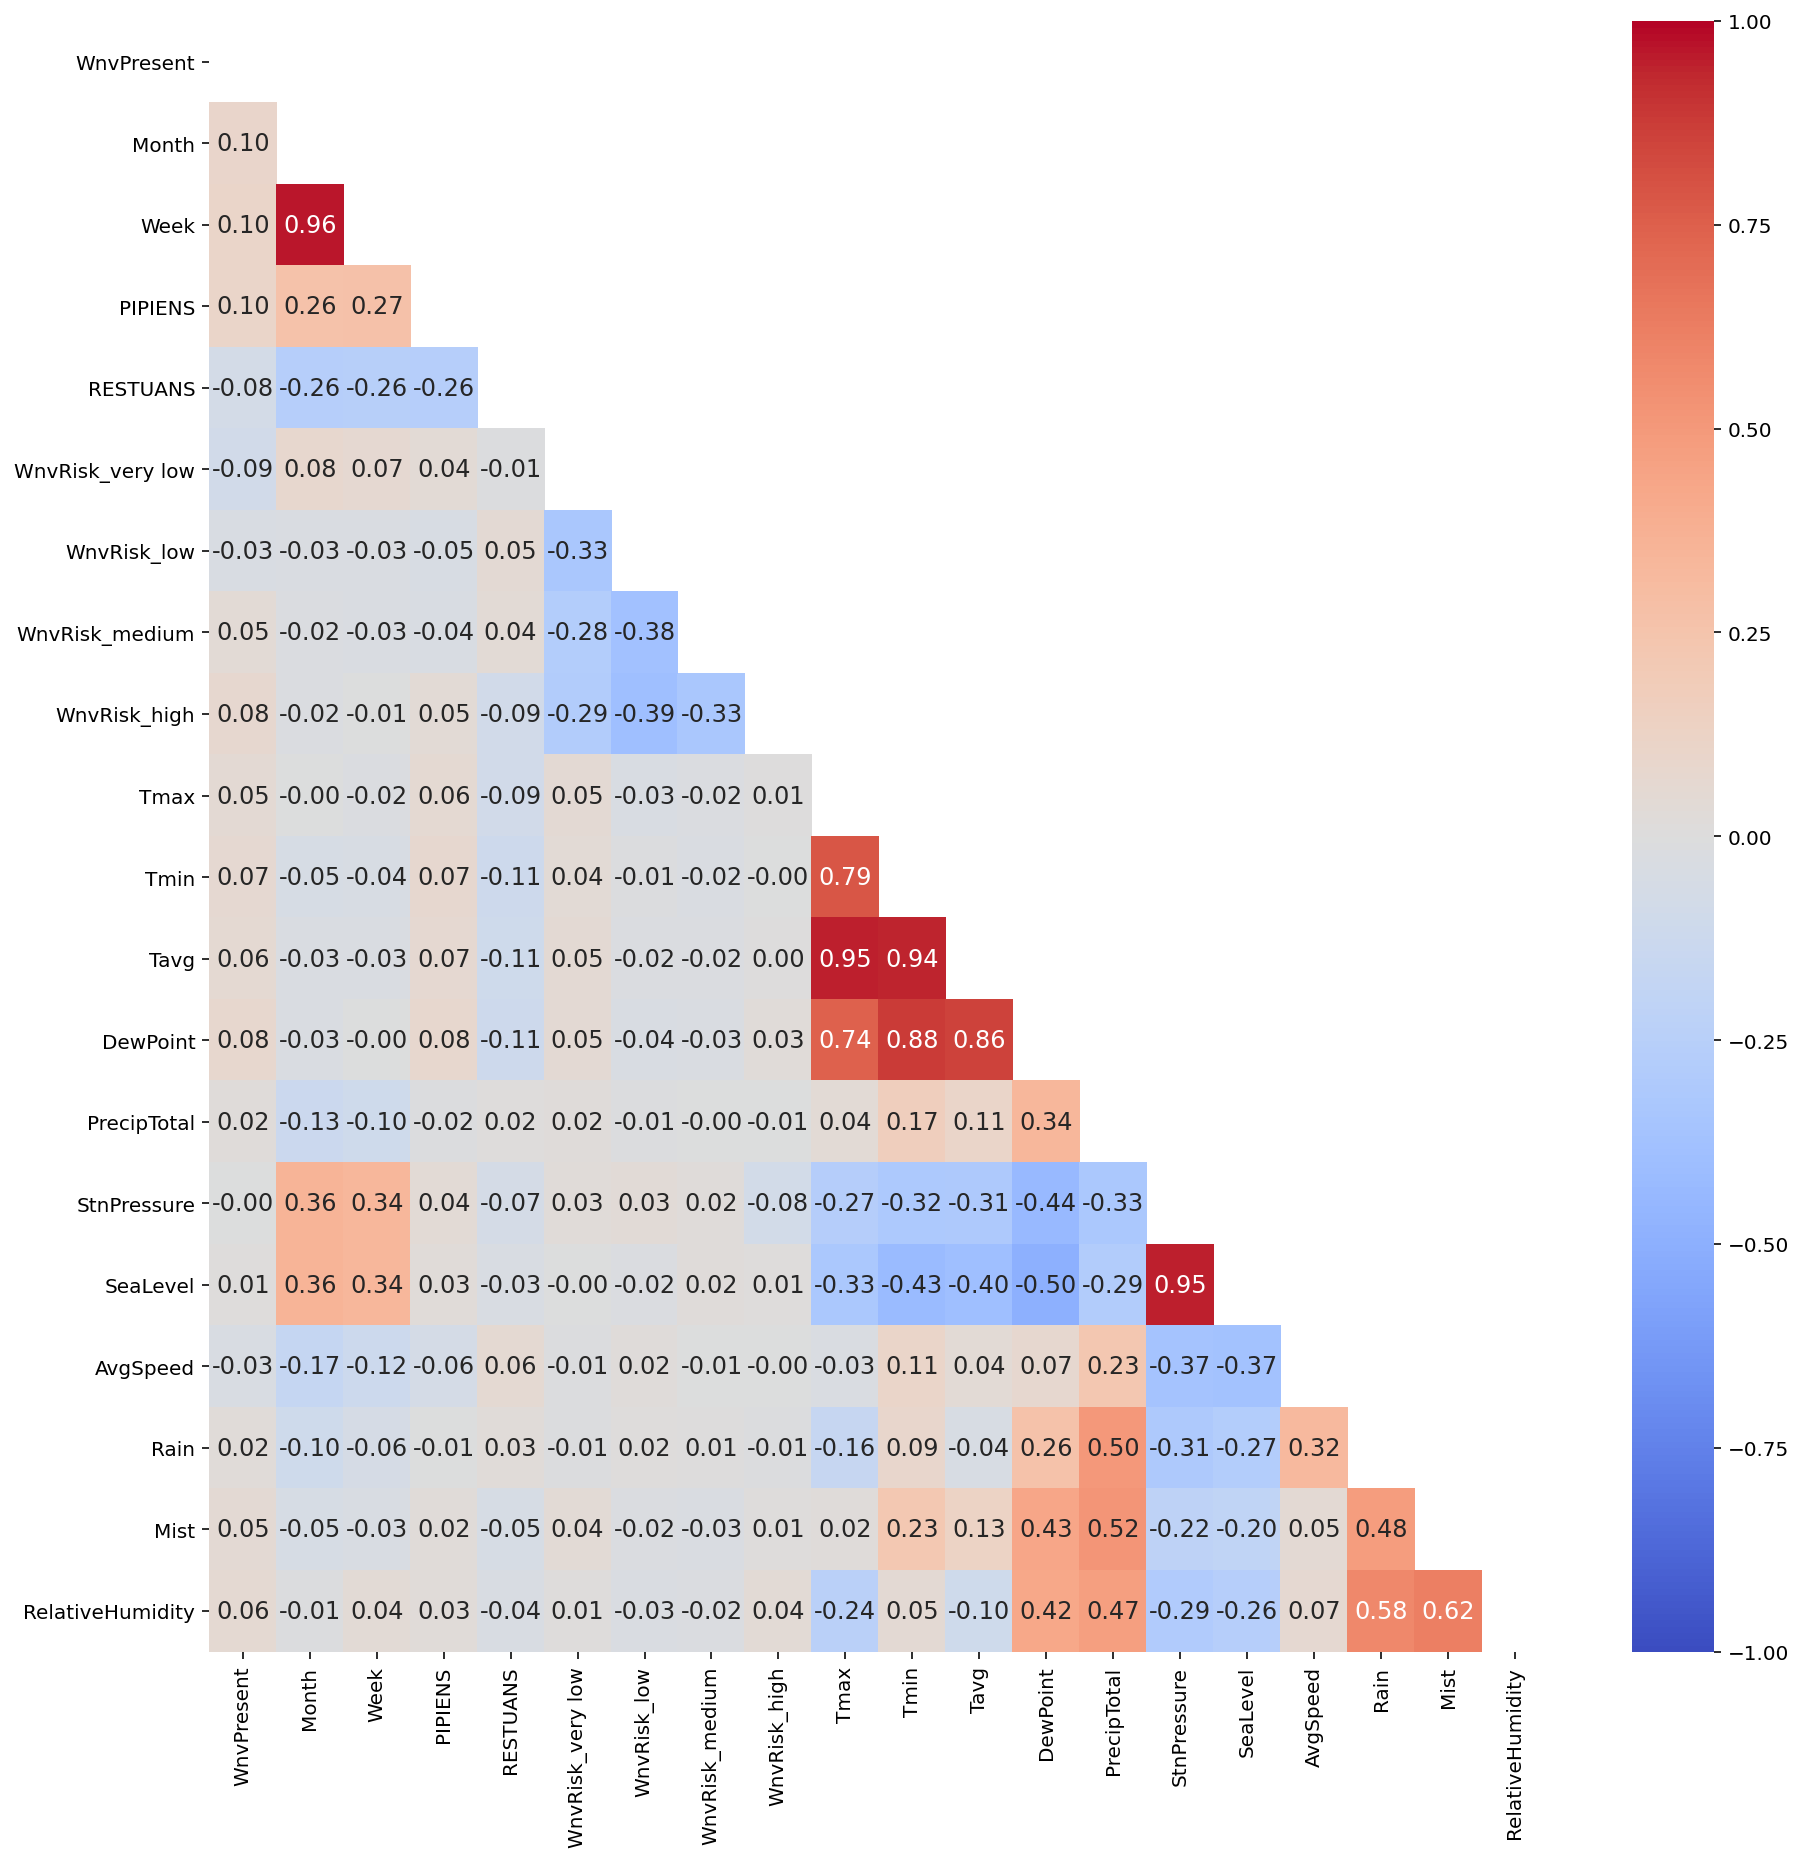

In [31]:
# plot a heatmap to look at the correlation matrix of the selected variables
# getting the Upper Triangle of the co-relation matrix
matrix = np.triu(df.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, mask= matrix, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

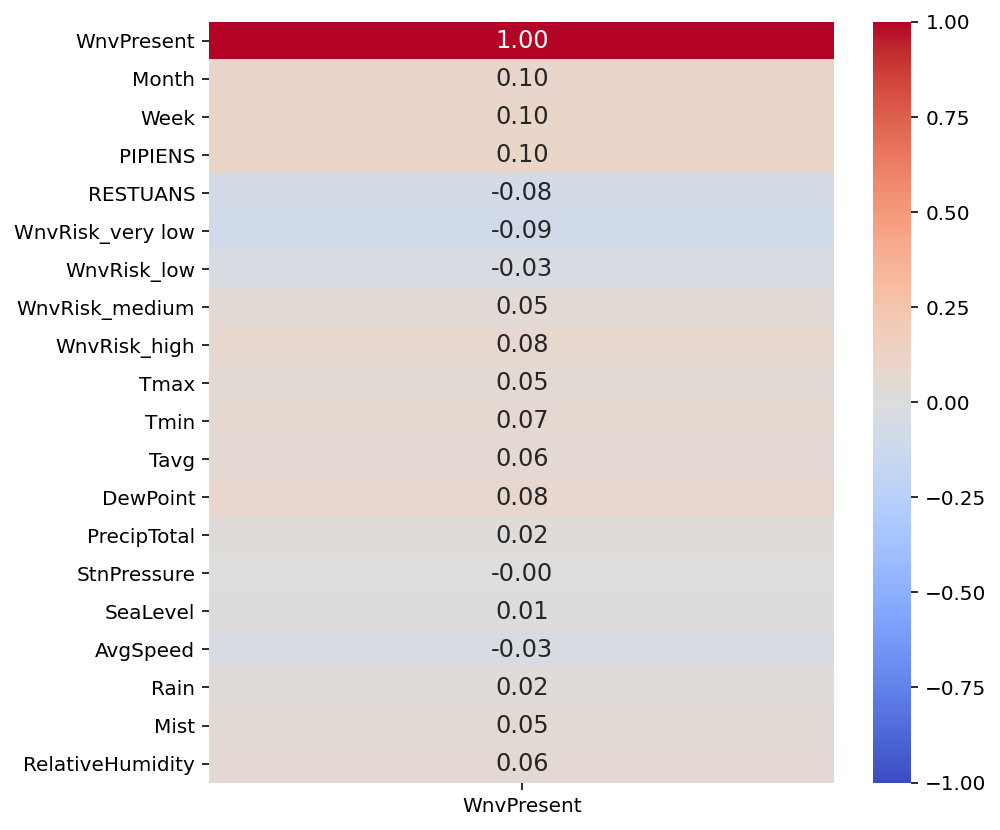

In [32]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr()[["WnvPresent"]], annot=True, cmap="coolwarm", 
           fmt=".2f", annot_kws={"size":12}, vmin=-1, vmax=1);

In [33]:
# drop data not required for modelling
train_merged_df.drop([ "AddressNumberAndStreet", "Latitude", "Longitude", 
                              "NumMosquitos", "Year", "Trap"], axis=1, inplace=True)

In [34]:
train_merged_df.shape

(10506, 23)

In [35]:
train_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              10506 non-null  datetime64[ns]
 1   WnvPresent        10506 non-null  int64         
 2   Month             10506 non-null  int64         
 3   Week              10506 non-null  UInt32        
 4   Year Month        10506 non-null  object        
 5   PIPIENS           10506 non-null  int64         
 6   RESTUANS          10506 non-null  int64         
 7   WnvRisk_very low  10506 non-null  uint8         
 8   WnvRisk_low       10506 non-null  uint8         
 9   WnvRisk_medium    10506 non-null  uint8         
 10  WnvRisk_high      10506 non-null  uint8         
 11  Station           10506 non-null  int64         
 12  Tmax              10506 non-null  int64         
 13  Tmin              10506 non-null  int64         
 14  Tavg              1050

Now with the merged datasets, let's explore relationshipS across datasets

In [36]:
def inspect_dt(groupby_lvl:str):
    # summarize by selected date metric
    plot_df = pd.DataFrame(pd.pivot_table(data=train_merged_df, index=groupby_lvl, values=['WnvPresent', 'Tmin', 'Tmax', 'Tavg', 'DewPoint', 'PrecipTotal', 'SeaLevel', 'AvgSpeed'], aggfunc=np.mean).to_records())
       
    features = plot_df.drop([groupby_lvl,  'WnvPresent'],axis='columns').columns.tolist()
    for f in features:
        fig, axes = plt.subplots(nrows=2, ncols=1,  figsize=(25, 6), sharex=True)
        plot_df.plot(x=groupby_lvl, y= f , ax=axes[0], marker='o', title=f)
        #plot_df.plot(x=groupby_lvl, y="NumMosquitos", marker='o', ax=axes[1])
        plot_df.plot(x=groupby_lvl, y="WnvPresent", marker='o', ax=axes[1])
        groupby_list = plot_df[groupby_lvl].unique().tolist()
        plt.xticks(np.arange(len(groupby_list)), labels = groupby_list, rotation=45)
        #fig.xticklabels(groupby_list)

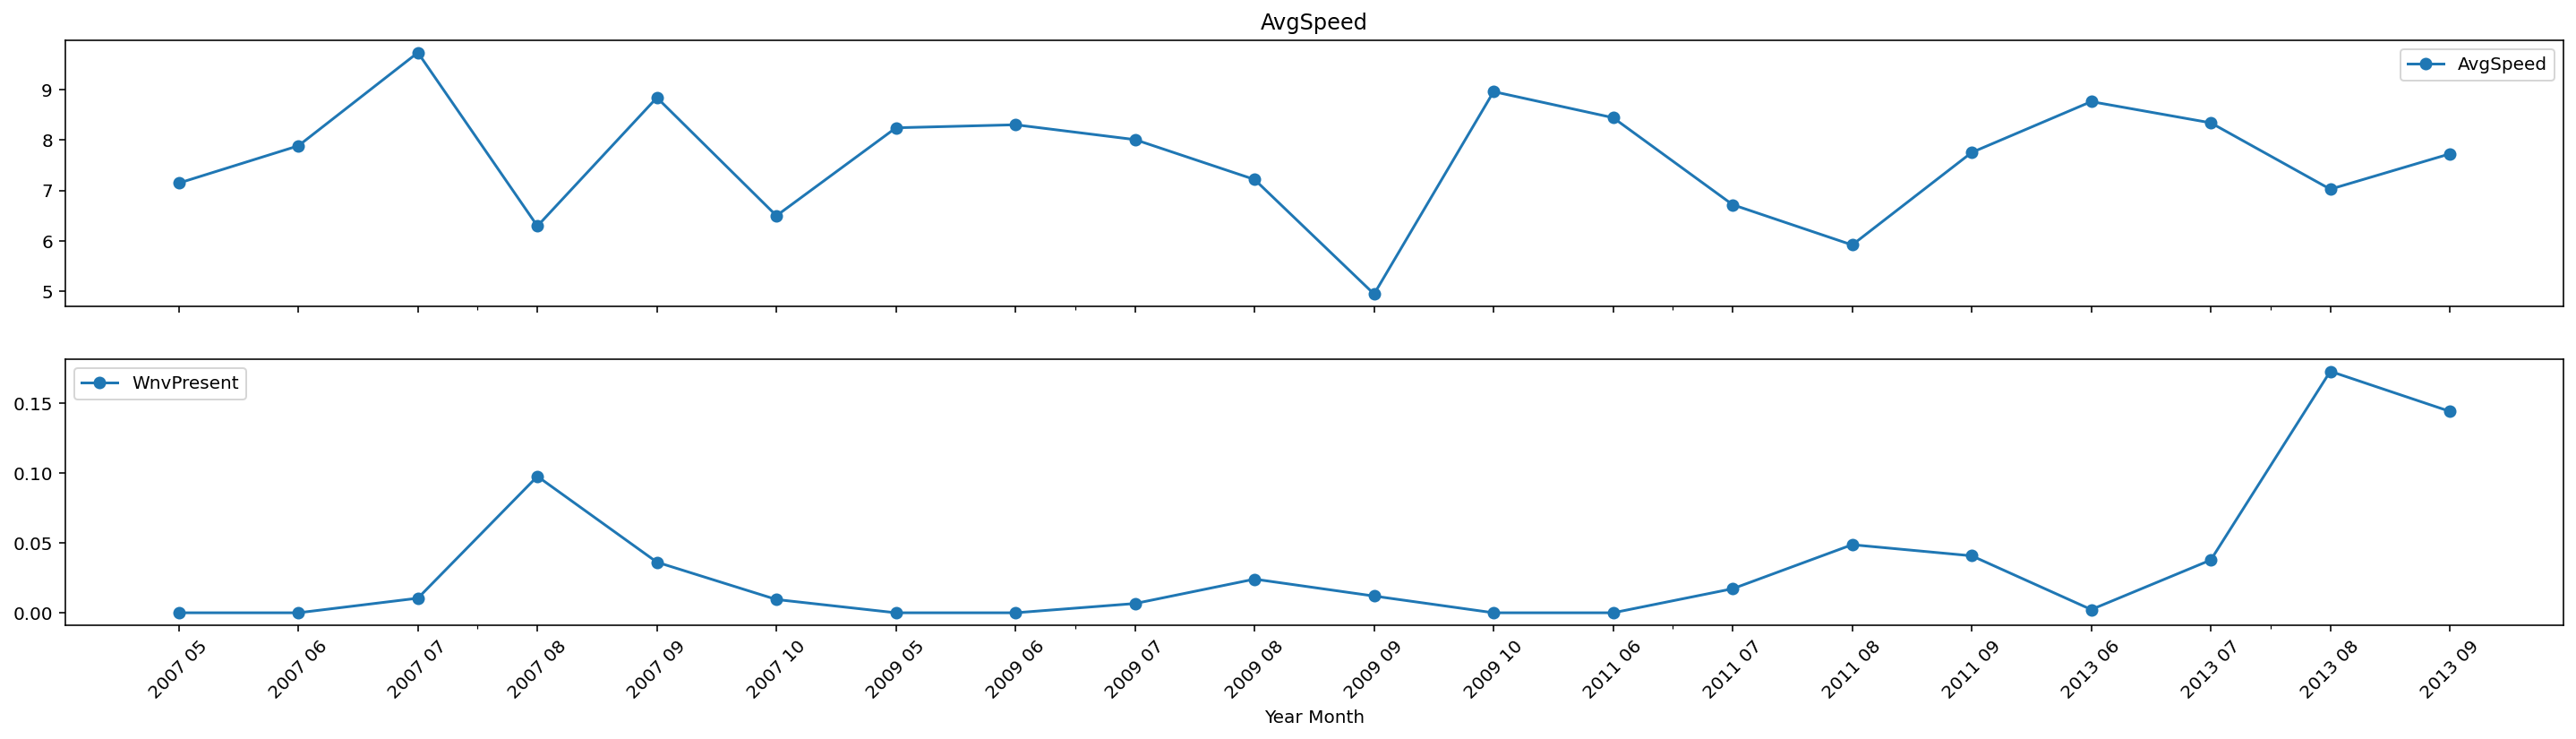

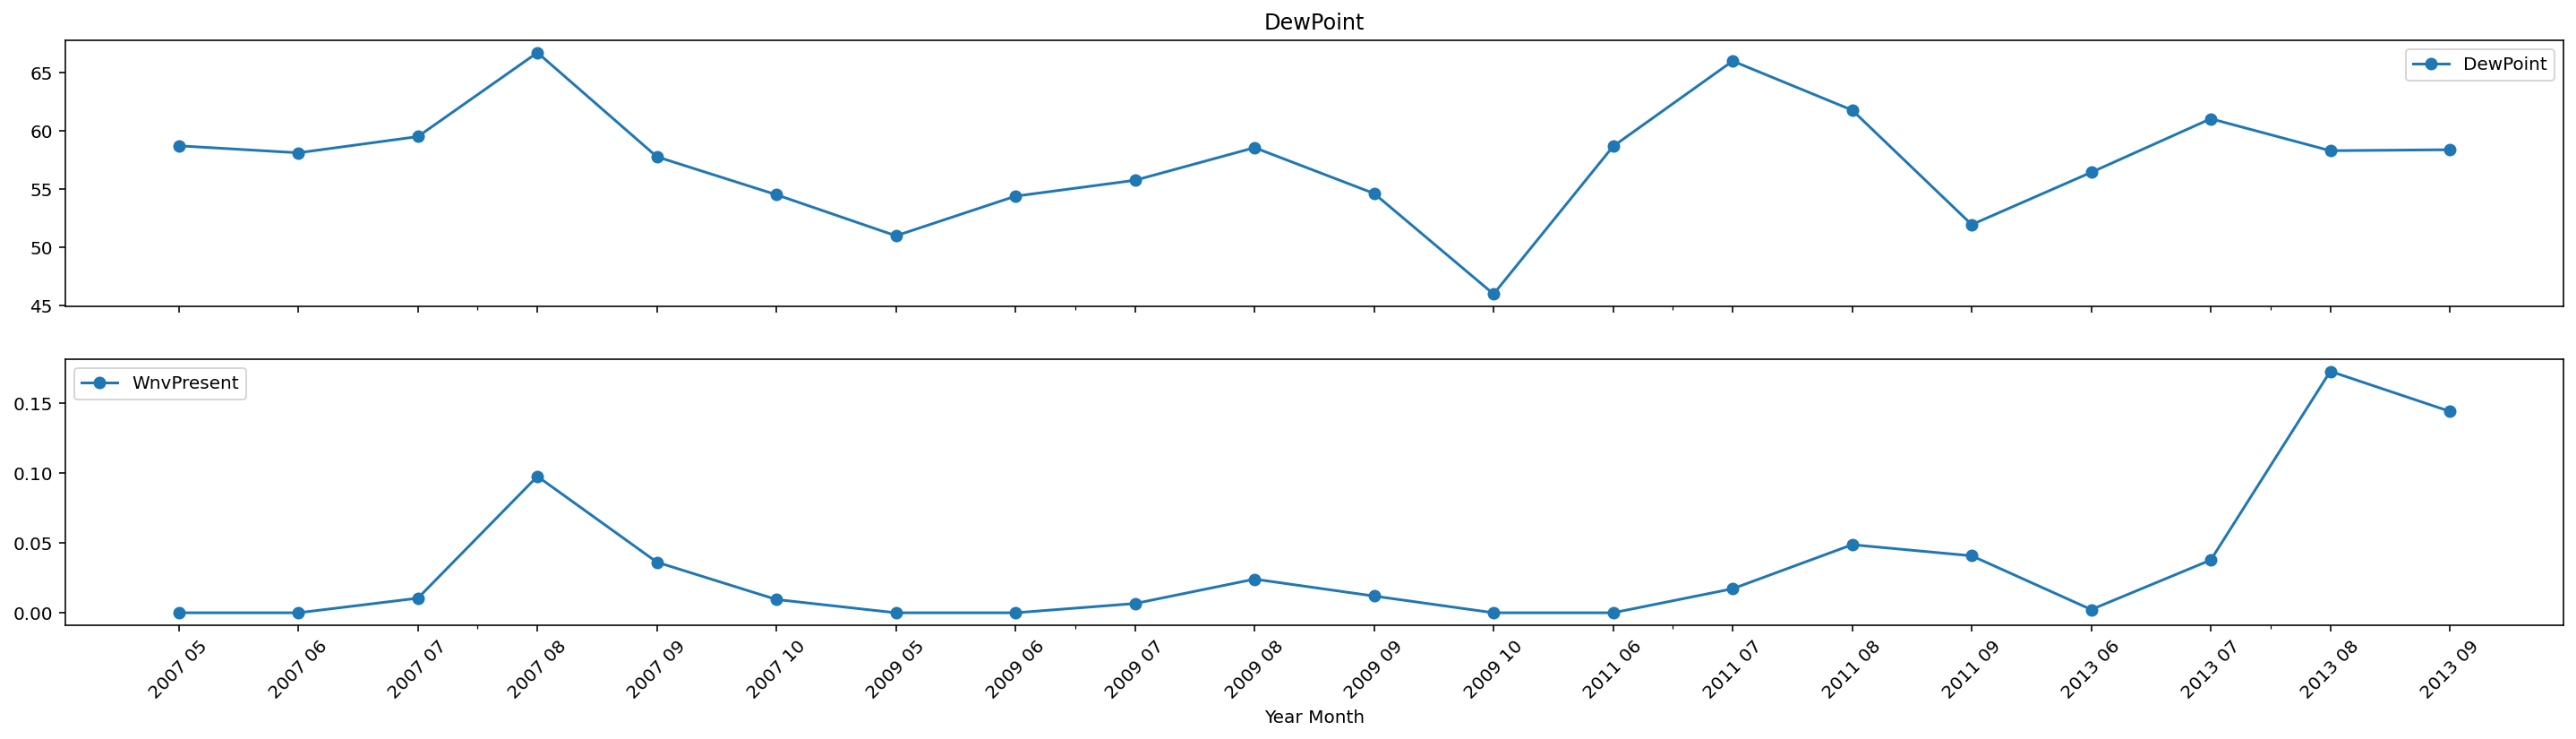

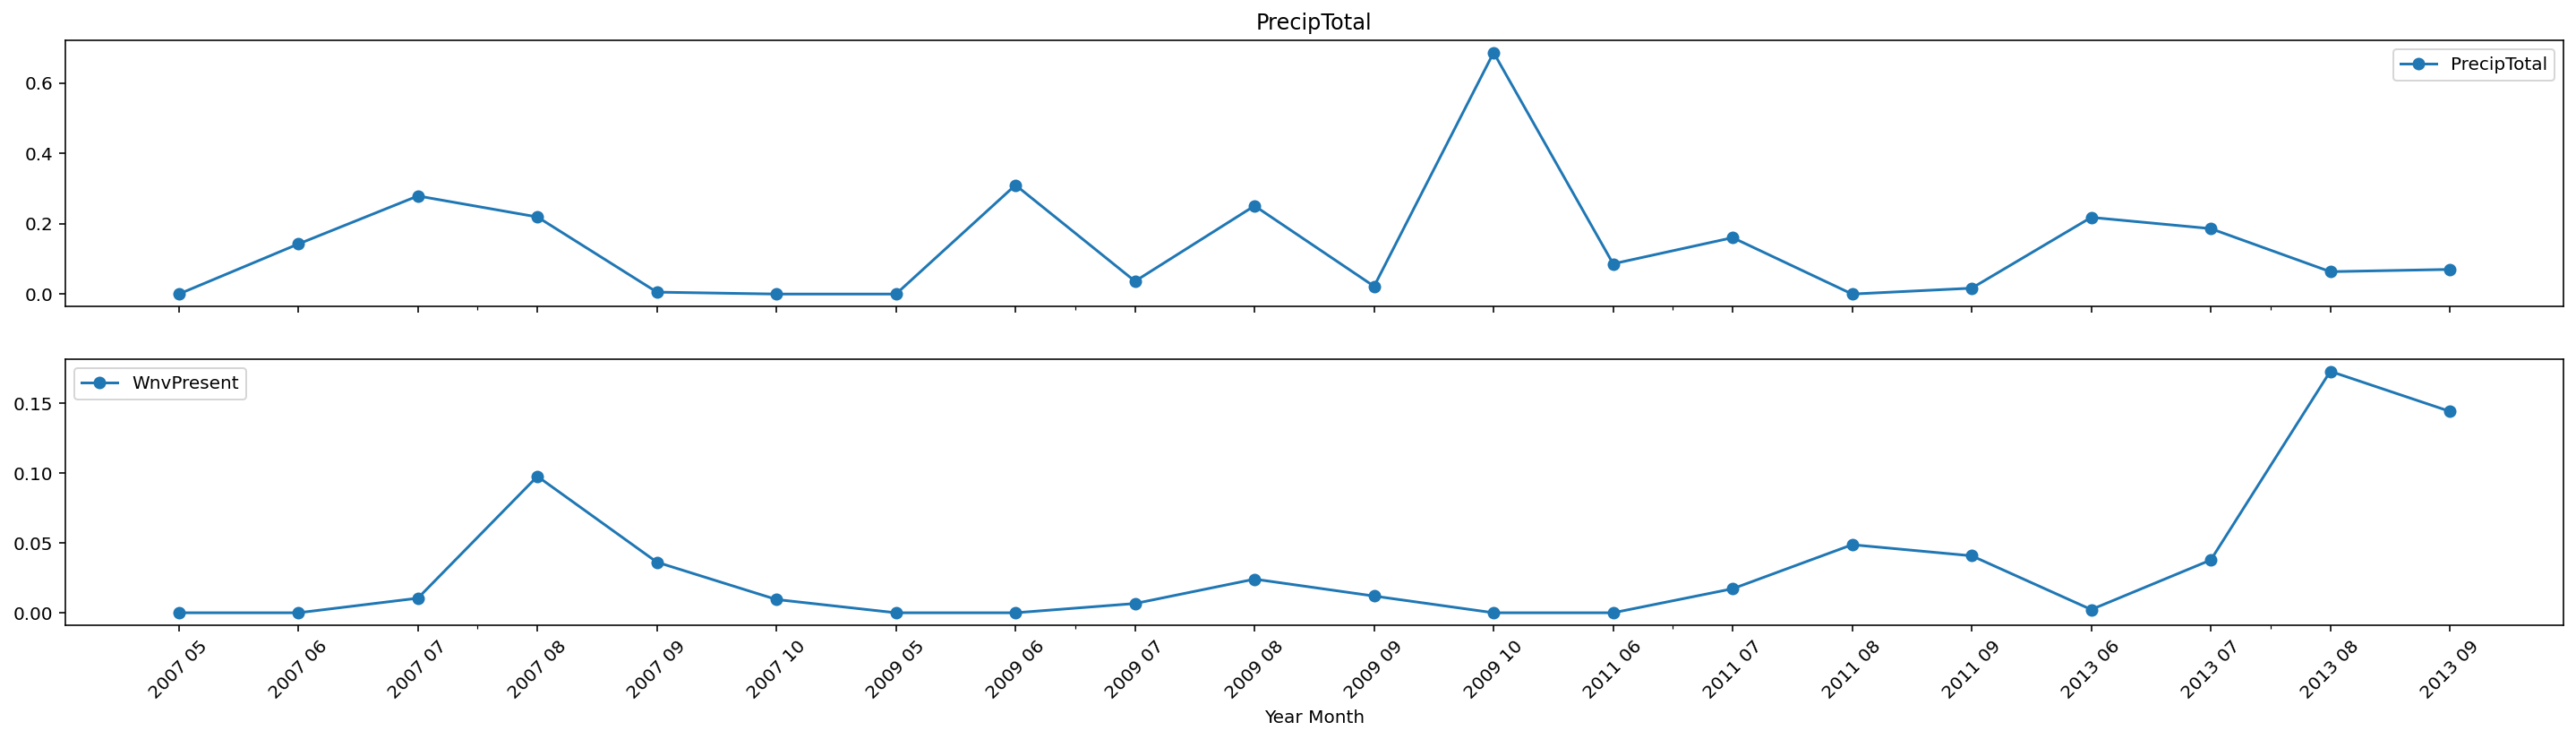

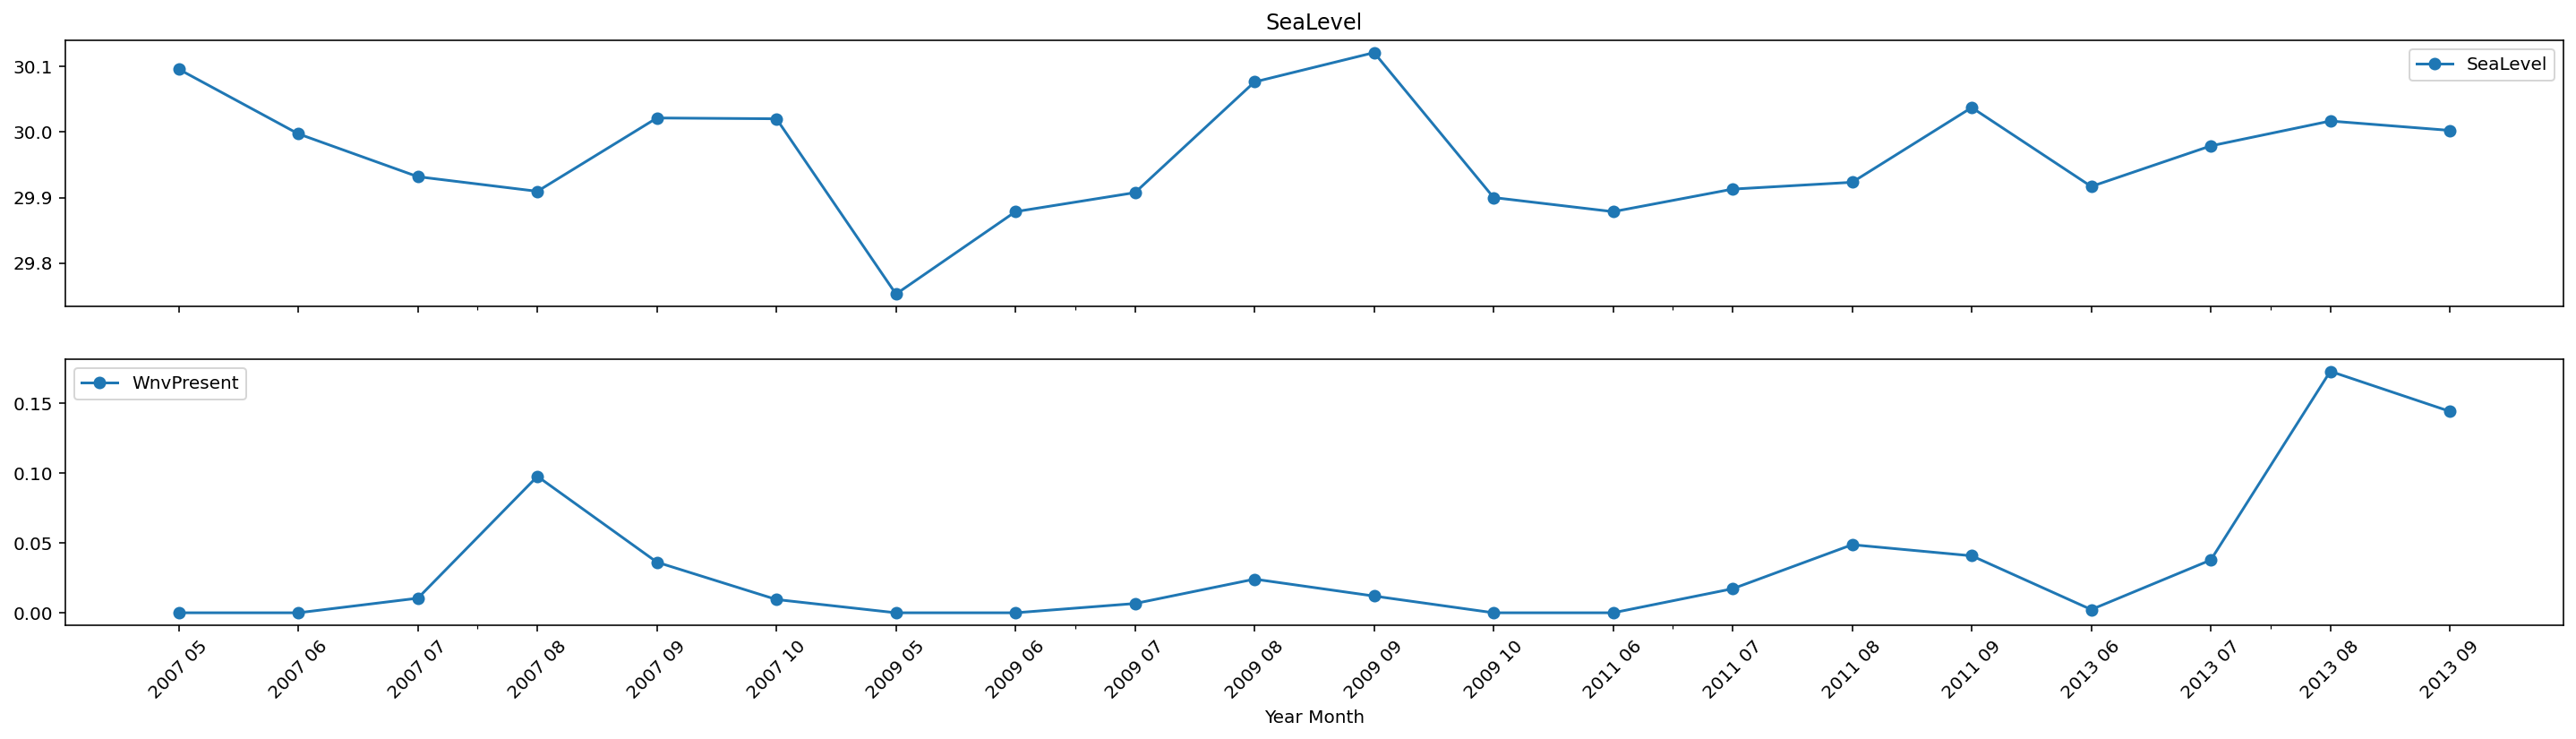

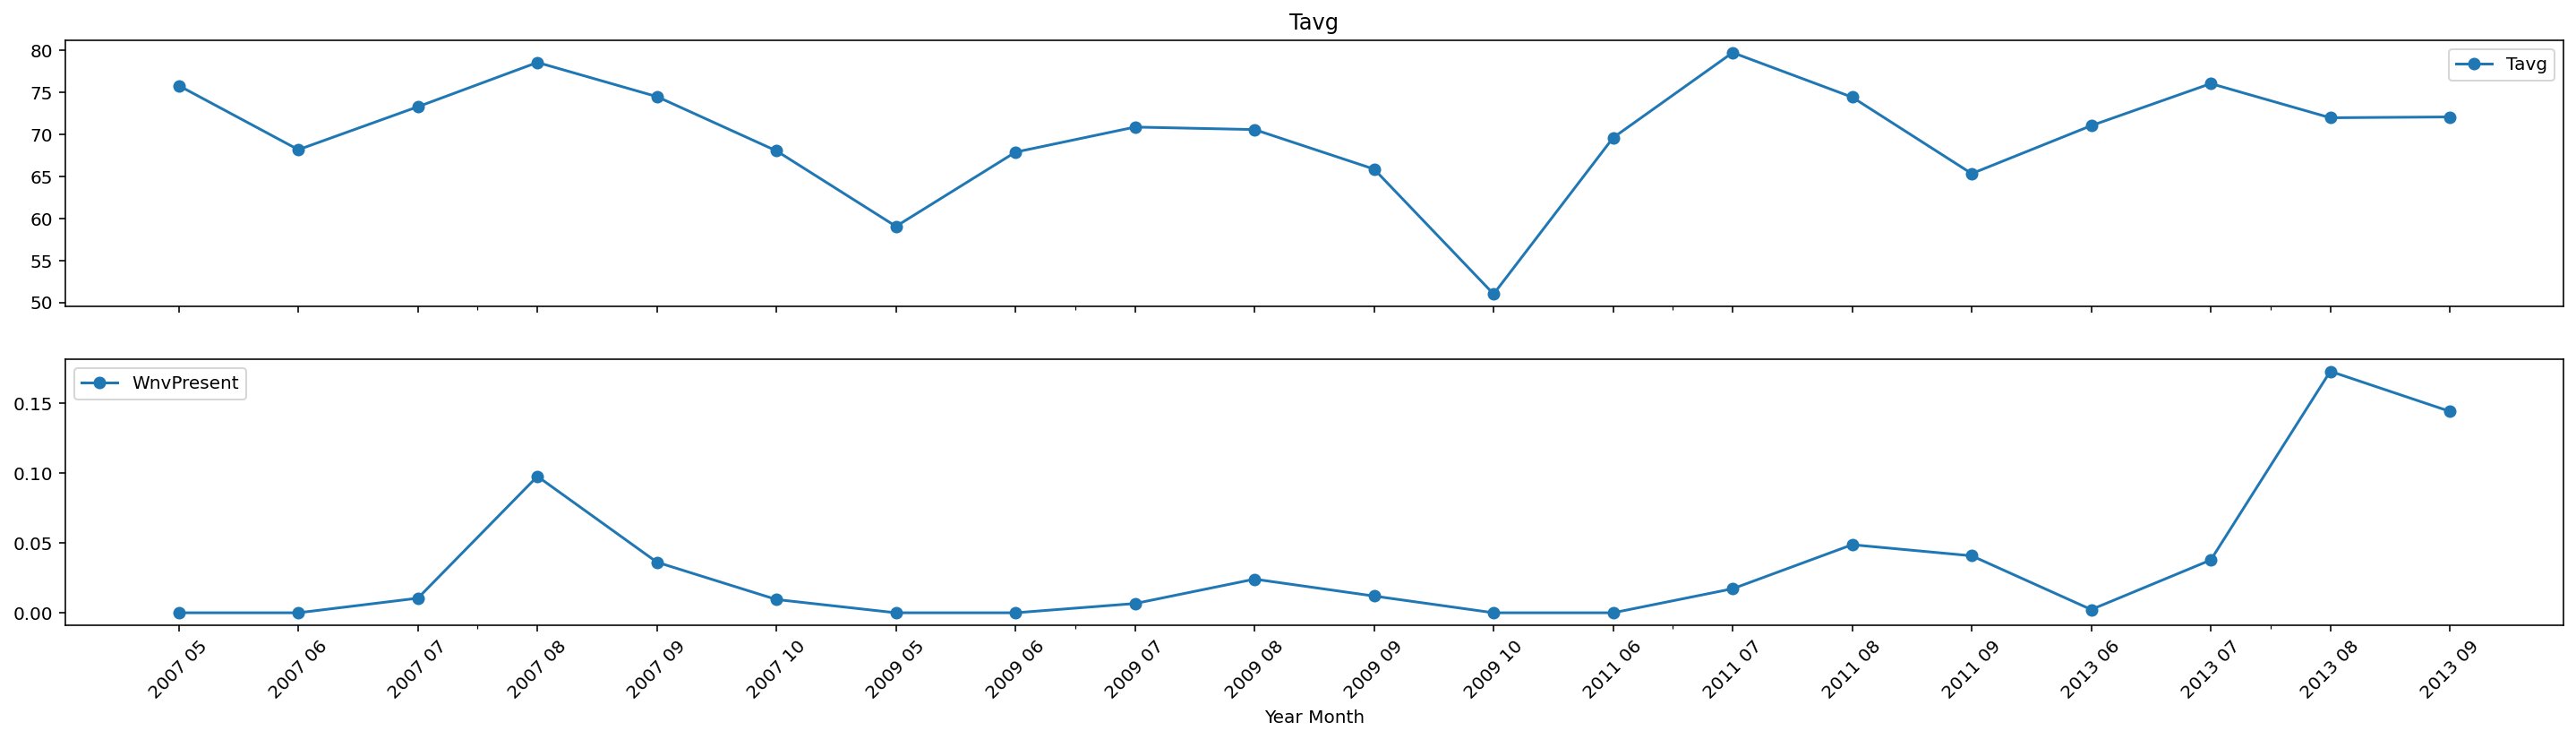

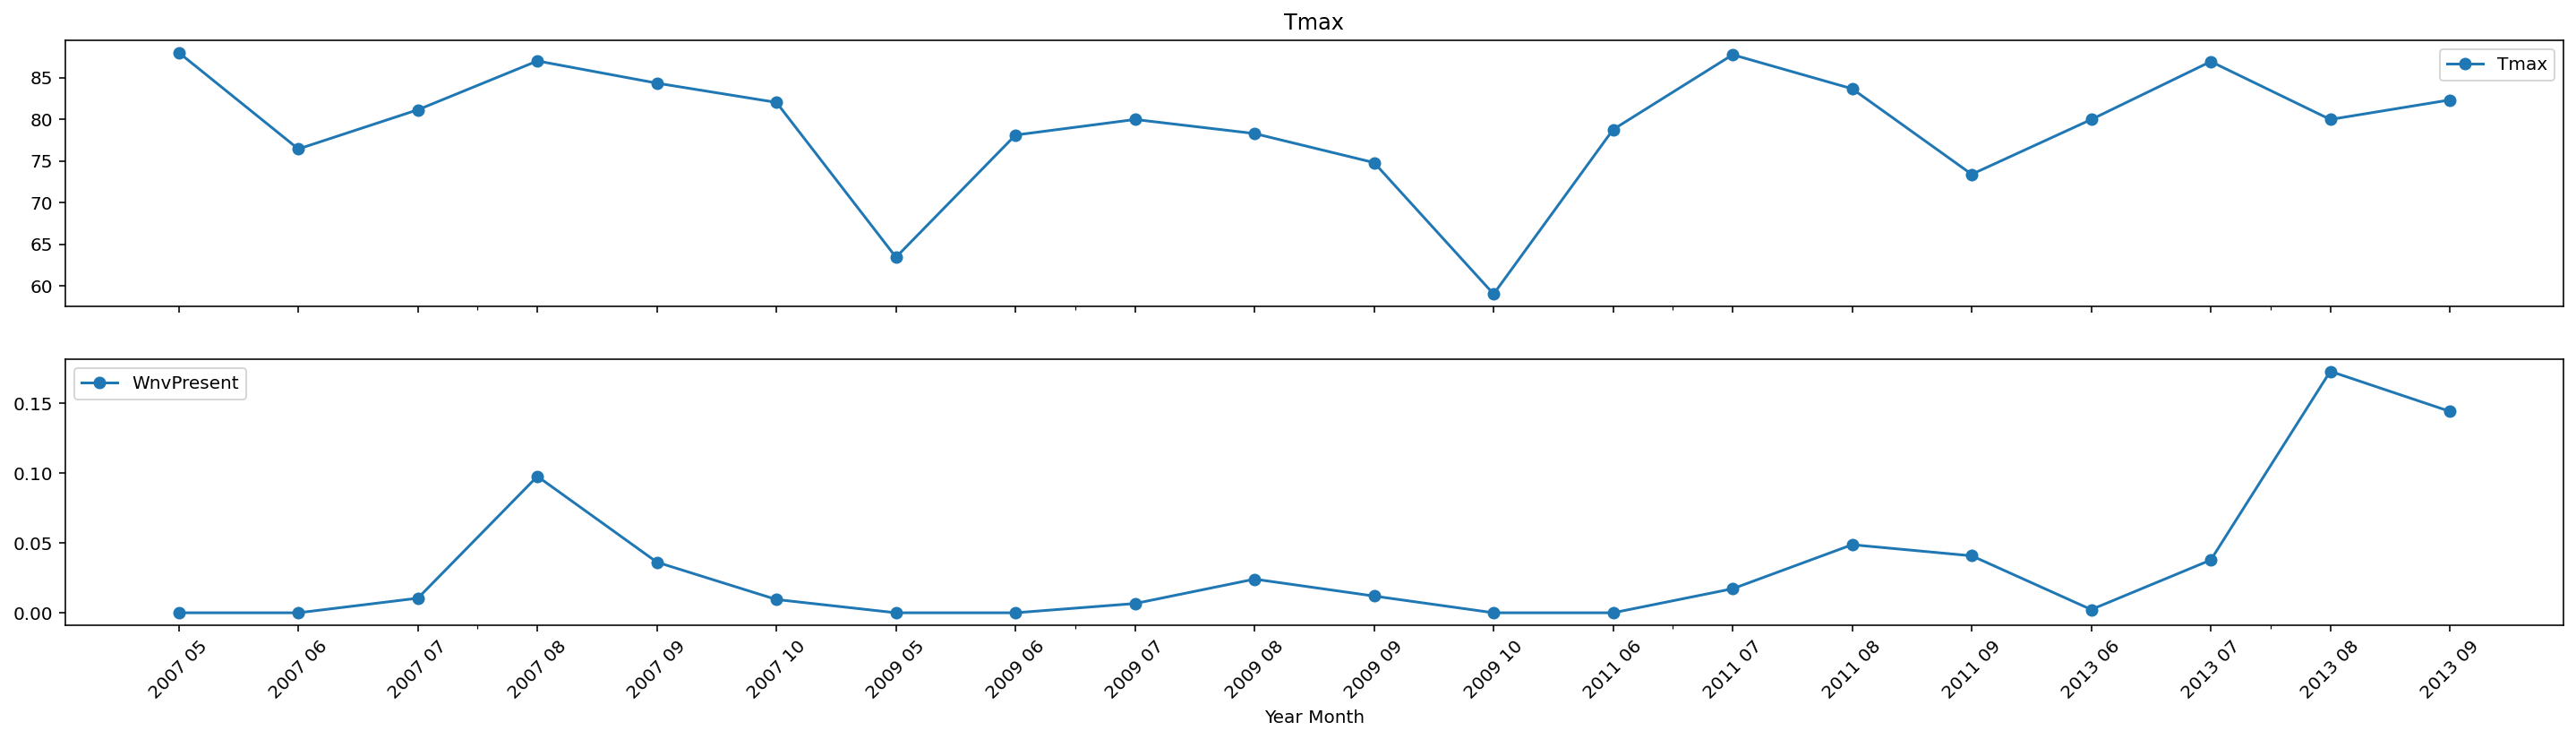

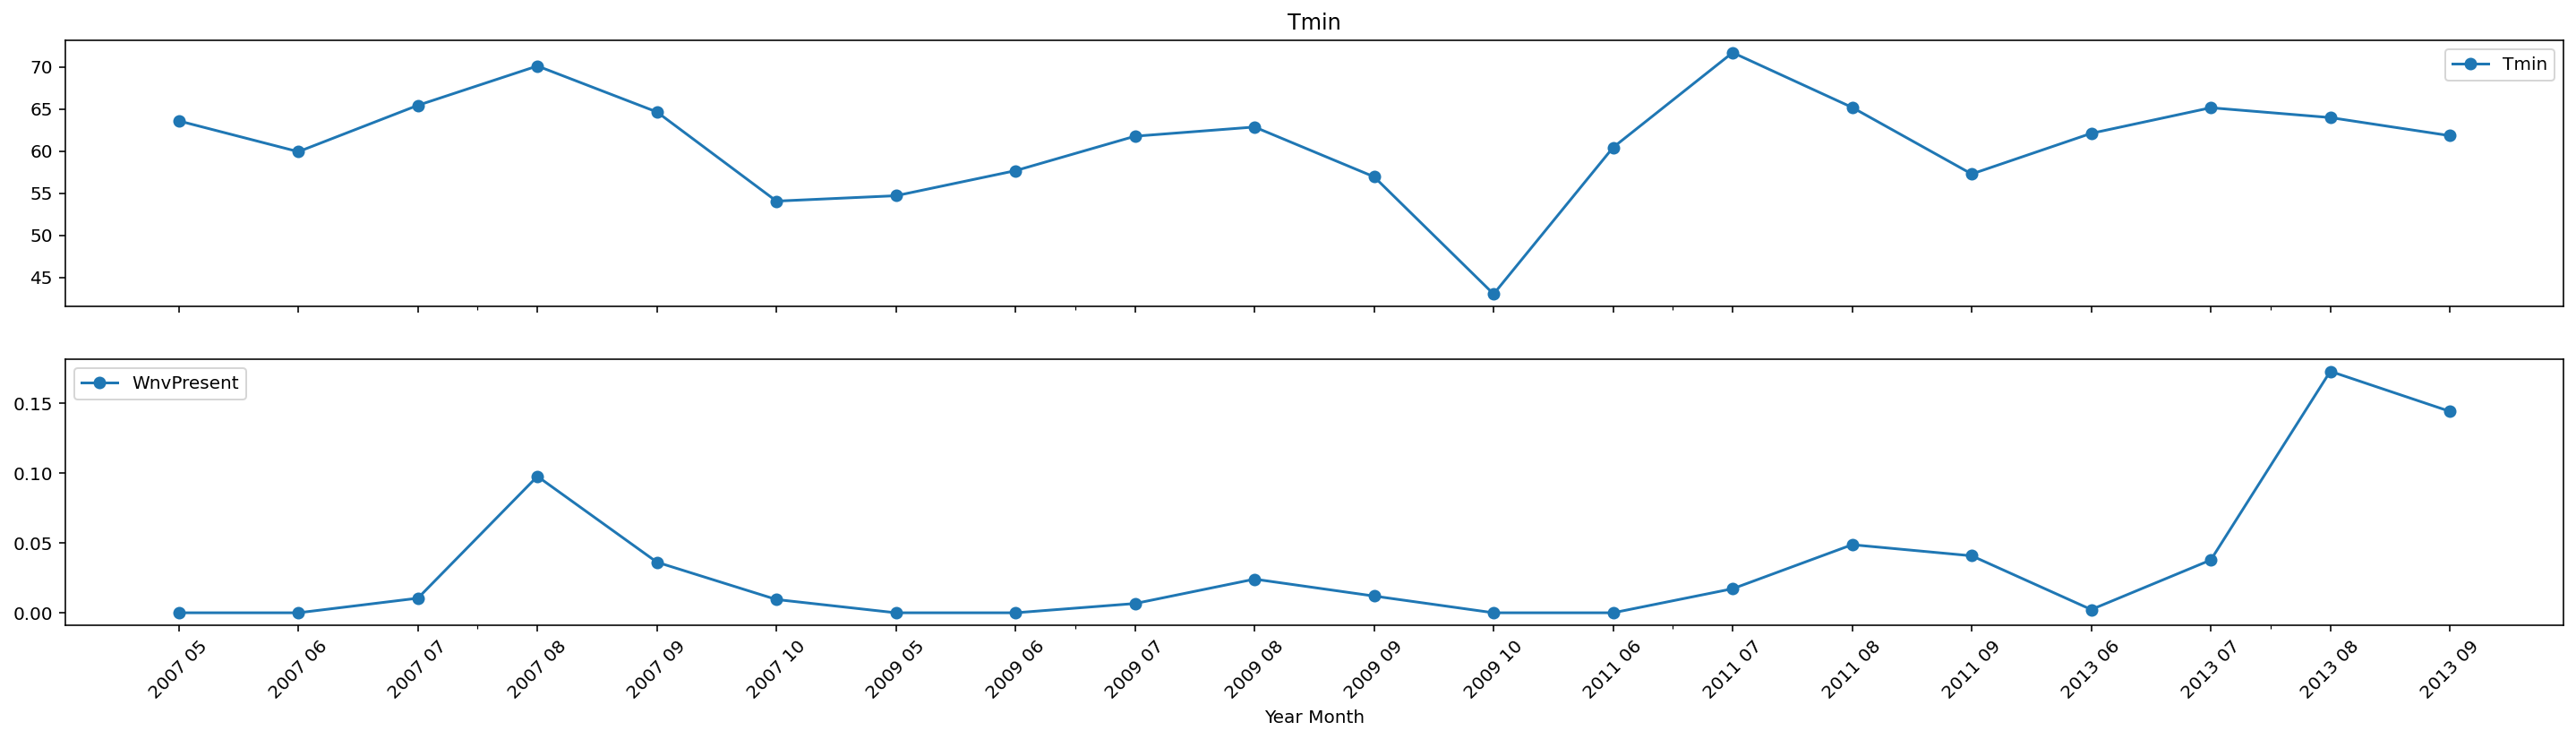

In [37]:
inspect_dt('Year Month')

### Observations
* NumMosquitos: Generally a lag between the number of mosquitos & presence of virus. i.e if Mosquito numbers are high this month, we can expect presence of virus will increase within the next 2 month
* Avgspeed, Tmin, Tmax seems to lag NumMosquitos by one month
* Dewpoint Preciptotal, Tavg: Has immediate impact on NumMosquitos
* SeaLevel: Immediate negative impact on Mosquitos

In [38]:
weather.head()

Station       Date  Tmax  Tmin  Tavg  DewPoint  PrecipTotal  StnPressure  \
0        1 2007-05-01    83    50  66.5        51          0.0        29.10   
1        2 2007-05-01    84    52  68.0        51          0.0        29.18   
2        1 2007-05-02    59    42  50.5        42          0.0        29.38   
3        2 2007-05-02    60    43  51.5        42          0.0        29.44   
4        1 2007-05-03    66    46  56.0        40          0.0        29.39   

   SeaLevel  AvgSpeed  Rain  Mist  RelativeHumidity  
0     29.82       9.2     0     0         57.394895  
1     29.82       9.6     0     0         54.497276  
2     30.09      13.4     0     1         72.508686  
3     30.08      13.4     0     1         69.872482  
4     30.12      11.9     0     0         54.848860

In [39]:
train_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              10506 non-null  datetime64[ns]
 1   WnvPresent        10506 non-null  int64         
 2   Month             10506 non-null  int64         
 3   Week              10506 non-null  UInt32        
 4   Year Month        10506 non-null  object        
 5   PIPIENS           10506 non-null  int64         
 6   RESTUANS          10506 non-null  int64         
 7   WnvRisk_very low  10506 non-null  uint8         
 8   WnvRisk_low       10506 non-null  uint8         
 9   WnvRisk_medium    10506 non-null  uint8         
 10  WnvRisk_high      10506 non-null  uint8         
 11  Station           10506 non-null  int64         
 12  Tmax              10506 non-null  int64         
 13  Tmin              10506 non-null  int64         
 14  Tavg              1050

In [40]:
def add_weather_stats(df: pd.DataFrame) -> pd.DataFrame:
    # Adding Year Month columns to aggregrate weather data by year and month
    weather['Year_Month'] = weather['Date'].dt.strftime('%Y %m')
    
    # Creating a temporary pivot table to extract weather states by year month
    temp_df = pd.DataFrame(pd.pivot_table(data=weather, index=['Station','Year_Month'], values=['Tmin', 'Tmax', 'DewPoint', 'PrecipTotal', 'SeaLevel', 'AvgSpeed', 'RelativeHumidity'], aggfunc='mean').to_records())
    
    # Rename temp_df columns
    old_col = temp_df.drop('Station', axis='columns').columns
    new_col = old_col + "_"
    temp_df = temp_df.rename(columns = dict(zip(old_col.tolist(), new_col.tolist())))
    
    # Assigning aggregated year month values into train_merged_df from temp_df
    for item in new_col[1:]:
        df = temp_df[['Station', 'Year_Month_', item]].merge(df, how='right', left_on=['Station', 'Year_Month_'], right_on=['Station', 'Year Month'])  \
                                                                     .rename(columns={item: item + 'L0'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
        
        df = temp_df[['Station', 'Year_Month_', item]].merge(df, how='right', left_on=['Station', 'Year_Month_'], right_on=['Station', 'Year Month L1'])  \
                                                                     .rename(columns={item: item + 'L1'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
        
    
    return df

In [41]:
train_merged_df = add_weather_stats(train_merged_df)

KeyError: 'Year Month L1'

In [ ]:
print(train_merged_df.info())
train_merged_df.head()

In [ ]:
# merge only values that contain no missing values 
train_merged_df = train_merged_df[(train_merged_df['Year Month'] != '2007 05') & (train_merged_df['Year Month'] != '2009 05')]
train_merged_df = train_merged_df.drop(['Year Month', 'Year Month L1', 'Station', 'Date'], axis='columns')
train_merged_df.info()

## c. Model Preparation

### 1. Create features matrix (X) & target vector (y)

In [ ]:
# create features matrix (X)
X = train_merged_df.drop(["WnvPresent"], axis=1)

# create target vector (y)
y = train_merged_df["WnvPresent"]

In [ ]:
X.info()

In [ ]:
# Do a train-test split of 70-30 for train-test
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,stratify=y, random_state=42)

In [ ]:
# Print the shape of train and test to ensure the split is 75-25
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

### 2. Include polynomial features for non-linear relationships

In [ ]:
# generates the full polynomial feature table
pf = PolynomialFeatures(include_bias=False, degree=2)
X_train_pf = pf.fit_transform(X_train)

# Adds appropriate feature names to all polynomial features
X_train_pf = pd.DataFrame(X_train_pf,columns=pf.get_feature_names(X_train.columns))
print(X_train_pf.info())

In [ ]:
# Generates list of poly feature correlations
corr = X_train_pf.corrwith(y_train)

poly_feat = corr[(corr.notnull()) & (abs(corr) >= 0.5)].sort_values(ascending=False).index.tolist()
poly_feat

In [ ]:
abs(corr).max()

None of the polynomial features have absolute correlation stronger than 0.5 (max absolute correlation is 0.3216, which is weak)

### 3. Addressing the target class imbalance
SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique that generates synthetic samples from the minority class. It is used to obtain a synthetically class-balanced or nearly class-balanced training set, which is then used to train the classifier.

In [ ]:
# show class imbalance
print(y_train.value_counts(normalize=True))

In [ ]:
# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
    else:
        pipe.fit(X_train, y_train)
        
    auc_scores = cross_val_score(pipe, X_train, y_train,  scoring='roc_auc', cv = 5)
    acc_scores = cross_val_score(pipe, X_train, y_train,  scoring='accuracy', cv = 5)

    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]

    results['model'] = mod
    
    results['train_auc_cv_mean'] = auc_scores.mean()
    results['train_acc_cv_mean'] = acc_scores.mean() 
    
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['auc_diff'] = results['train_auc'] - results['test_auc']

    results['train_acc'] = pipe.score(X_train, y_train)
    results['test_acc'] = pipe.score(X_test, y_test)       
    results['acc_diff'] = results['train_acc'] - results['test_acc']

    results['recall'] = recall_score(y_test, predictions)           # % OF ACTUAL positives that are CORRECTLY predicted
    results['precision'] = precision_score(y_test, predictions)           # % OF positives that are CORRECTLY predicted

    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)

    
    return pipe

In [ ]:
X_train_copy = X_train.astype(float).copy()
y_train_copy = y_train.astype(float).copy()

for k in ['None', 'Over', 'Under', 'SMOTE', 'Weights']:
    print('\nMethod Used: {}'.format(k + 'sampling' if k == 'Under' or k == 'Over' else k), "-" * 100)
    
    weight = None
    
    print('\nClass Balance BEFORE')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]))
  
    # instiantiate the models
    methods = {'Over': RandomOverSampler(sampling_strategy="not majority"), # String,
              'Under': RandomUnderSampler(sampling_strategy=1),
              'SMOTE': SMOTE(random_state=42),
            }
    if k == 'None':
        weight = None
    if k == 'Weights':
        weight = 'balanced'
    if k in ['Over', 'Under', 'SMOTE']:
        mthd = methods[k]
        X_train, y_train = mthd.fit_resample(X_train, y_train)
        weight = None
    
    print('\nClass Balance AFTER')
    display(y_train.value_counts(normalize=True))
    print('Number of rows: {}'.format(y_train.shape[0]),'\n')
    
    
    # Instiantiate models
    models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, class_weight=weight, solver='saga'),
              'rf': RandomForestClassifier(random_state=42, class_weight=weight),
              'gb': GradientBoostingClassifier(random_state=42),
              'dt': DecisionTreeClassifier(random_state=42, class_weight=weight),
              'et': ExtraTreesClassifier(random_state=42, class_weight=weight),
              'ada': AdaBoostClassifier(random_state=42),
              'svc': SVC(random_state=42, probability=True, class_weight=weight),
            }

    # Instantiate lists to store results
    init_list = []
    gs_list = []

    for m in models:
        run_model(m)
    result_df = pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)
    display(result_df)

    X_train = X_train_copy
    y_train = y_train_copy


## d. Model Selection & Evaluation
We select the best model based on recall score and ROC AUC scores (the higher, the better).

### Comparing the 7 models, the Gradient Boosting Classifier performed the best.

It produced the highest receiver operating characteristic area under curve (ROC AUC) score for the test set (0.843). It also has the second highest cross-validated ROC AUC (0.976) and cross-validated accuracy score exceeding 0.91. The model seems stronger than the Decision Tree, Extra Trees and Random Forest Classifiers because it is less overfitted to the train data. In terms of the training-testing ROC AUC difference, it is the second smallest with a difference of 0.136. However, in terms of the training-testing accuracy difference, it is the 4th smallest with a difference of 0.041.

In [ ]:
print('\nClass Balance BEFORE')
display(y_train.value_counts(normalize=True))
print('Number of rows: {}'.format(y_train.shape[0]))

# instiantiate the methods
sm = SMOTE(random_state=42)  
X_train, y_train = mthd.fit_resample(X_train, y_train)

    
print('\nClass Balance AFTER')
display(y_train.value_counts(normalize=True))
print('Number of rows: {}'.format(y_train.shape[0]),'\n')


# instantiate lists to store results
gs_list = []


gb_best = run_model('gb', 
          mod_params={
              'gb__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
              'gb__n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'gb__max_depth': [3, 5, 8]
          },
          grid_search=True)
    
X_train = X_train_copy
y_train = y_train_copy    

In [ ]:
gb_result_df = pd.DataFrame(gs_list).reset_index(drop=True)
display(gb_result_df)

In [ ]:
def plot_confusion_matrix(y_test, test_preds):
    cm = confusion_matrix(y_test, test_preds)
    modified_cm = []
    for index,value in enumerate(cm):
        if index == 0:
            modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
        if index == 1:
            modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

    TN, FP, FN, TP = cm.ravel()

    print("Precison: {:.3f} (TP / (TP + FP))".format(TP / (TP + FP)))
    print("Recall: {:.3f} (TP / (TP + FN))".format(TP / (TP + FN)))
    print("F1 Score: {:.3f} (2*TP / (2*TP + FN + FP))".format(2*TP / (2*TP + FN + FP)), '\n')
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=np.array(modified_cm),
                fmt="",
                annot_kws={"size": 10},
                linewidths=.5,
                square = True,
                cmap = 'Blues',
                xticklabels = ['bitcoin', 'ethereum'],
                yticklabels = ['bitcoin', 'ethereum'],
                )

    plt.ylabel('Actual', fontsize = 10);
    plt.xlabel('Predicted', fontsize = 10);
    plt.title('Confusion Matrix of Predictions Made by \n Gradient Boosting Classifier on Testing Data', 
          fontweight='bold', fontsize=10);
    plt.tick_params(labelsize= 8)

In [ ]:
gb_best.best_estimator_

In [ ]:
feature_names = X.columns
df_impt = pd.DataFrame(np.squeeze(gb_best.best_estimator_.named_steps["gb"].feature_importances_),columns=['Importances']) 
df_names = pd.DataFrame(np.squeeze(feature_names), columns=['Features']) 
feat_df = pd.concat([df_names, df_impt], axis='columns').sort_values('Importances', ascending=False)
feat_df

In [ ]:
# plot confusion matrix
plot_confusion_matrix(y_test, gb_best.best_estimator_.predict(X_test))

In [ ]:
y_pred_prob = gb_best.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("ROC_AUC_Score: {}".format(roc_auc_score(y_test, y_pred_prob)))

In [ ]:
wnv_risk.reset_index().columns

In [ ]:
train

In [ ]:
# import cleaned datasets/ original Kaggle datasets 
test = pd.read_csv("../assets/test.csv", parse_dates=[1])
weather = pd.read_csv("../assets/weather_cleaned.csv", parse_dates=[1])

In [ ]:
test.info()

In [ ]:
weather.info()

### Setting up preprocessing functions

In [ ]:
def assign_station(lat:int, lng:int) -> int:
    coord_stn1 = (41.995, -87.933)
    coord_stn2 = (41.786, -87.752)
    coord_curr = (lat, lng)
    return 1 if geodesic(coord_curr, coord_stn1) < geodesic(coord_curr, coord_stn2) else 2

def clean_data(data:pd.DataFrame, weather)-> pd.DataFrame:
    data['Station'] = data.apply(lambda x: assign_station(x['Latitude'], x['Longitude']), axis=1)
      
    # merging 4 datasets into 1
    df = data.merge(weather, how='left', on=['Date', 'Station'])
    return df
    
def add_date_features(df:pd.DataFrame) -> pd.DataFrame:
    if df.index.inferred_type != "datetime64":
        df = df.set_index('Date')
    #df['Date'] = df.index.strftime('%Y %m %d')    
    #df['Year'] = df.index.strftime('%Y')
    df['Month'] = df.index.month
    df['Week'] = df.index.isocalendar().week
    df['Year Month'] = df.index.strftime('%Y %m')
    df['Year Month L1'] = df.index.date - pd.DateOffset(months=1)
    df['Year Month L1'] = df['Year Month L1'].dt.strftime('%Y %m')
#     for item in df['Month'].unique().tolist():
#         df['is_mth_' + item] = np.where(df['Month'] == item, 1, 0)
#   df = df.drop(['Year'], axis='columns')
    return df


def add_species_features(df:pd.DataFrame) -> pd.DataFrame:
    df['RESTUANS'] = np.where(df['Species'].str.lower().str.contains('restuans'), 1, 0)
    df['PIPIENS'] = np.where(df['Species'].str.lower().str.contains('pipiens'), 1, 0)
    df = df.drop(['Species'], axis='columns')
    return df

def add_weather_features(df:pd.DataFrame) -> pd.DataFrame:
    try:
        df['Rain'] = np.where(df['CodeSum'].str.contains('|'.join(['TS', 'RA', 'DZ', 'SH', 'SQ'])), 1, 0)
        df['Mist'] = np.where(df['CodeSum'].str.contains('|'.join(['BR', 'HZ', 'FG', 'FU'])), 1, 0)
        df = df.drop(['CodeSum'], axis='columns')
    except:
        return df
    return df


def add_location_features(df:pd.DataFrame) -> pd.DataFrame:
#     temp_df = pd.DataFrame(pd.pivot_table(df, index = ['AddressNumberAndStreet'], columns=['Year_Month'], values=['WnvPresent'], aggfunc='sum').to_records()).fillna(0)
#     old_col = temp_df.drop('AddressNumberAndStreet', axis='columns').columns.tolist()
#     new_col = np.sort(df['Year_Month'].unique()).tolist()
#     temp_df = temp_df.rename(columns = dict(zip(old_col, new_col)))

#     temp_df['TotalCases'] = temp_df.sum(axis='columns')
#     temp_df['risk_lvl'] = pd.cut(temp_df['TotalCases'], bins=[0, 2, 6, 10, 100], right=False, labels=['very low', 'low', 'medium', 'high'], ordered=True)
    #wnv_risk = pd.get_dummies(train_merged_df["WNV_risk"], prefix="WnvRisk")], axis=1)
    df = wnv_risk.reset_index()[['AddressNumberAndStreet', 'WNV_risk']].merge(df, how='right', on='AddressNumberAndStreet') # add risk level column
    df = pd.get_dummies(df, columns=['WNV_risk'], prefix='WnvRisk')

    return df

def add_weather_stats(df: pd.DataFrame) -> pd.DataFrame:
    # Adding Year Month columns to aggregrate weather data by year and month
    weather['Year_Month'] = weather['Date'].dt.strftime('%Y %m')
    
    # Creating a temporary pivot table to extract weather states by year month
    temp_df = pd.DataFrame(pd.pivot_table(data=weather, index=['Station','Year_Month'], values=['Tmin', 'Tmax', 'DewPoint', 'PrecipTotal', 'SeaLevel', 'AvgSpeed', 'RelativeHumidity'], aggfunc='mean').to_records())
    
    # Rename temp_df columns
    old_col = temp_df.drop('Station', axis='columns').columns
    new_col = old_col + "_"
    temp_df = temp_df.rename(columns = dict(zip(old_col.tolist(), new_col.tolist())))
    
    # Assigning aggregated year month values into train_merged_df from temp_df
    for item in new_col[1:]:
        df = temp_df[['Station', 'Year_Month_', item]].merge(df, how='right', left_on=['Station', 'Year_Month_'], right_on=['Station', 'Year Month'])  \
                                                                     .rename(columns={item: item + 'L0'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
        
        df = temp_df[['Station', 'Year_Month_', item]].merge(df, how='right', left_on=['Station', 'Year_Month_'], right_on=['Station', 'Year Month L1'])  \
                                                                     .rename(columns={item: item + 'L1'})  \
                                                                     .drop(['Year_Month_'], axis='columns')
        
    
    return df

def cleanup(df):
    df = df[(df['Year Month'] != '2007 05') & (df['Year Month'] != '2009 05')]
    df = df.drop(['Year Month', 'Year Month L1', 'AddressNumberAndStreet', 'Address', 'Block', 'Street', 'Trap', 'AddressAccuracy', 'Station'], axis='columns')
    return df


def predict(df):
    df_id = df['Id']
    
    df_base = df.drop(['Latitude','Longitude', 'Id'], axis='columns')
    
    # generate predictions
    y_pred = gb_best.best_estimator_.predict(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred), columns=['WNVPresent']) 

    

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_id, df_pred], axis='columns')
    return df_final

def predict_proba(df):
    df_coord = df[['Latitude', 'Longitude']]
    
    df_base = df.drop(['Latitude','Longitude', 'Id'], axis='columns')
    
    # generate predictions
    y_pred = gb_best.best_estimator_.predict_proba(df_base)  

    # load prediction into dataframe
    df_pred = pd.DataFrame(np.squeeze(y_pred)) 

    

    # Merge id with predictions into one dataframe
    df_final = pd.concat([df_coord, df_pred], axis='columns')
    return df_final

In [ ]:
data1 = test.pipe(clean_data, weather) \
             .pipe(add_date_features) \
             .pipe(add_species_features) \
             .pipe(add_weather_features) \
             .pipe(add_location_features) \
             .pipe(add_weather_stats)  \
             .pipe(cleanup)


data1.info()

assert data1.isnull().sum().sum() == 0

In [ ]:
data1.head()

In [ ]:
final_pred = predict(data1)
final_pred

In [ ]:
final_pred_proba = predict_proba(data1)
final_pred_proba

In [ ]:
final_pred.to_csv('../assets/Submission.csv', index=False)

In [ ]:
final_pred_proba.to_csv('../assets/prediction_probability.csv', index=False)